Timetracking: 1h

In [1]:
import pandas as pd
import joblib
import shap
from shap.maskers import Independent
import matplotlib.pyplot as plt
from comparers import ModelComparer, plot_decision_boundary, _encode_one_hot, _calc_log_odds_from_log_proba
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations
import numpy as np
import pandas as pd
import pickle
import cloudpickle
from matplotlib.colors import Normalize
import scipy as sp
from util import get_rules
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '03'

In [2]:
try:
    with open(task_name + '.models', 'rb') as f:
        comparer = pickle.load(f)
    with open(task_name + '.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
except FileNotFoundError:
    pass

In [3]:
X = pd.read_csv('test_data.csv')
y = X['price']
X = X.drop(columns=['Unnamed: 0', 'price'])
feature_names = X.columns.to_numpy()
class_names = y.unique().astype(str)
X

CRIM   ZN      INDUS       NOX        RM  AGE       DIS        RAD  \
0     5.438165  0.0  18.100000  0.713000  6.395536  2.0  2.331054  24.000000   
1    10.062300  0.0  18.100000  0.584000  6.833000  2.0  2.088200  24.000000   
2     0.402020  0.0   9.900000  0.544000  6.382000  1.0  3.532500   4.000000   
3     0.290900  0.0  21.890000  0.624000  6.174000  2.0  1.611900   4.000000   
4     0.250659  0.0   9.542886  0.532534  5.743817  1.0  4.153345   3.880564   
..         ...  ...        ...       ...       ...  ...       ...        ...   
241   6.801170  0.0  18.100000  0.713000  6.081000  1.0  2.717500  24.000000   
242   0.402820  0.0   6.200000  0.504000  8.137837  2.0  3.169809   8.000000   
243   3.774980  0.0  18.100000  0.655000  5.952000  1.0  2.871500  24.000000   
244   0.344745  0.0  21.890000  0.624000  5.685295  2.0  1.814662   4.000000   
245   1.232470  0.0   8.140000  0.538000  6.142000  2.0  3.976900   4.000000   

            TAX    PTRATIO      LSTAT  
0    666.000000  20.200000  16.525663  
1    666.000000  20.200000  19.690000  
2    304.000000  18.400000  10.360000  
3    437.000000  21.200000  24.160000  
4    295.520027  18.340282  12.371885  
..          ...        ...        ...  
241  666.000000  20.200000  14.700000  
242  307.000000  17.400000   3.344242  
243  666.000000  20.200000  17.150000  
244  437.000000  21.200000  17.348228  
245  307.000000  21.000000  18.720000  

[246 rows x 11 columns]

In [4]:
clf_a = joblib.load('model_A.joblib')
clf_b = joblib.load('model_C.joblib')

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


# Comparing decision boundaries of two different classifier models

In [5]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)
with open(task_name + '.models', 'wb') as f:
    cloudpickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

Let's plot all feature against all other features and color the instances red, that have different predictions:

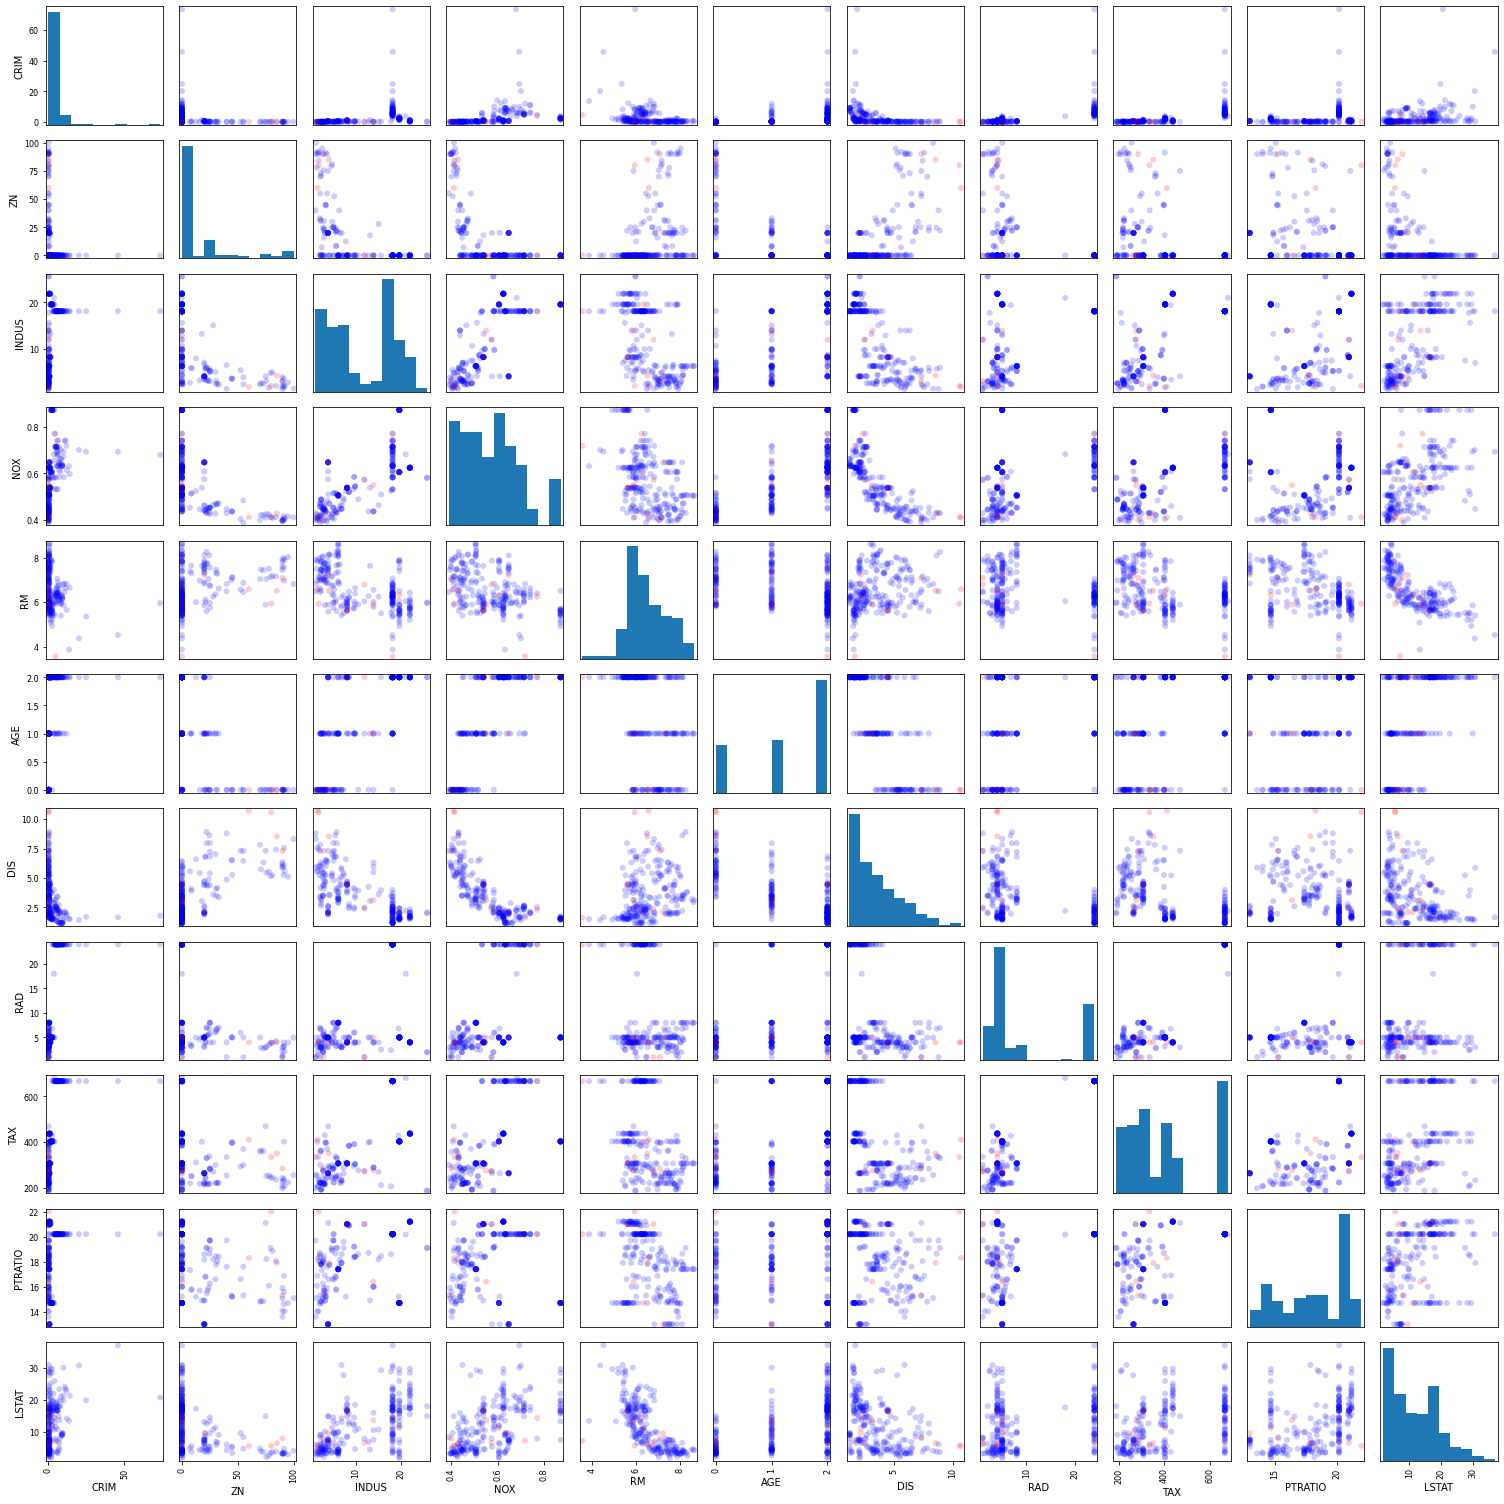

In [6]:
df = pd.DataFrame(X, columns=feature_names)
cmap = plt.get_cmap('rainbow')
is_pred_diff = comparer.predict_bin_diff(X)
colors = ['r' if v else 'b' for v in is_pred_diff]
axes = pd.plotting.scatter_matrix(df, figsize=(21, 21), marker='o', alpha=0.2, c=colors)
plt.tight_layout()

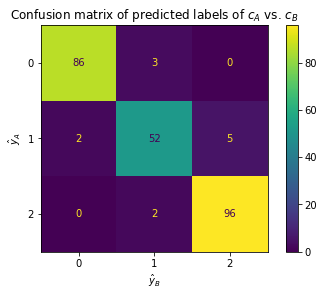

In [7]:
comparer.plot_confusion_matrix(X)

We have a few instances in four different confusion classes now.

# Generate SHAP values

In [8]:
%%time
masker = Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite),
                f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 247it [00:18,  7.20it/s]                         
Permutation explainer: 247it [00:14,  4.78it/s]                         
Permutation explainer: 247it [00:38,  4.54it/s]                         

CPU times: user 2min 3s, sys: 11.4 s, total: 2min 14s
Wall time: 1min 11s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [9]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

In [10]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

In [5]:
feature_idx_of = lambda feature_name: np.where(comparer.feature_names == feature_name)[0][0]
class_idx_of = lambda class_name: np.where(comparer.class_names == class_name)[0][0]

# Global Explanations

## Feature importance

### Individual explanations

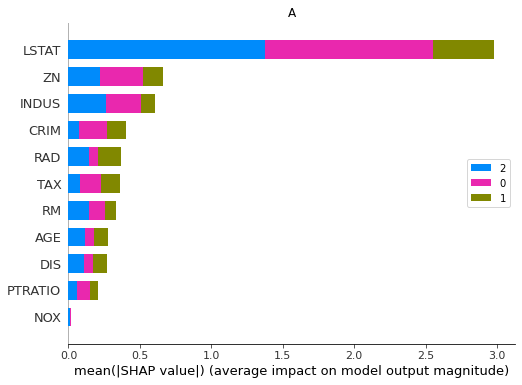

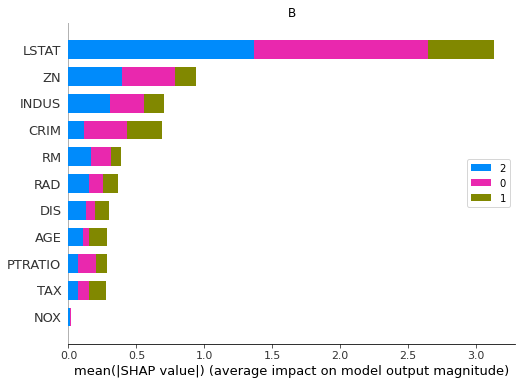

In [12]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)
plot_feature_importance_bar(explanations.indiv.log_odds.A, title='A', feature_order=feature_order)
plot_feature_importance_bar(explanations.indiv.log_odds.B, title='B', feature_order=feature_order)

In the absolute mean of the SHAP value difference, everything is as expected, with a similar order like above. AGE does not have a higher importance, compared to A vs. B.

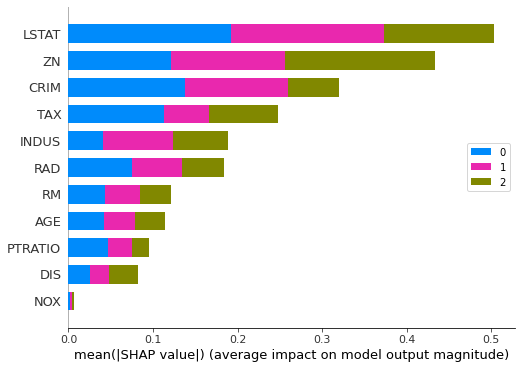

In [13]:
plot_feature_importance_bar(explanations.indiv_diff.log_odds)

### Difference classifier explanations

In the feature order, we see that LSTAT ranks highest, the rest being a lot less important for the differences.

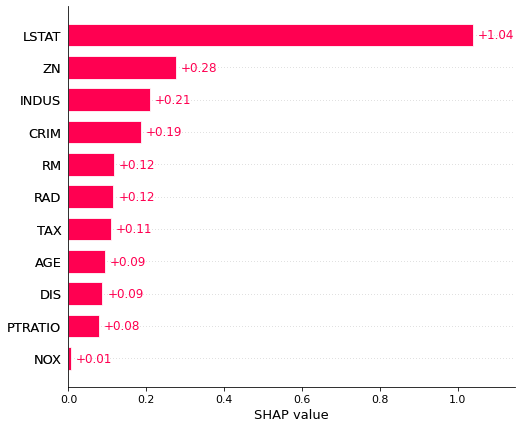

In [7]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importance)

It's very similar, when analyzing the mean absolute SHAP value per class.

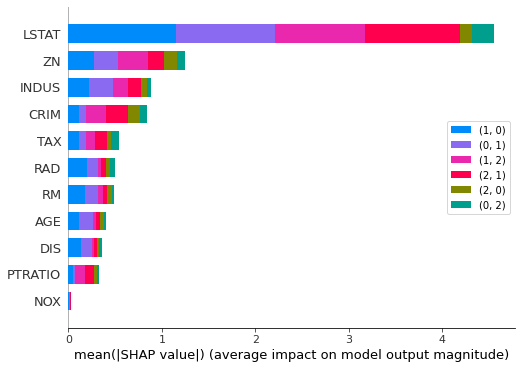

In [8]:
plot_feature_importance_bar(explanations.mclass_diff.log_odds[:, :, comparer.difference_class_names])

The shap value distribution for LSTAT looks pretty much the same, compared to A vs. B, except that the values are more extreme.

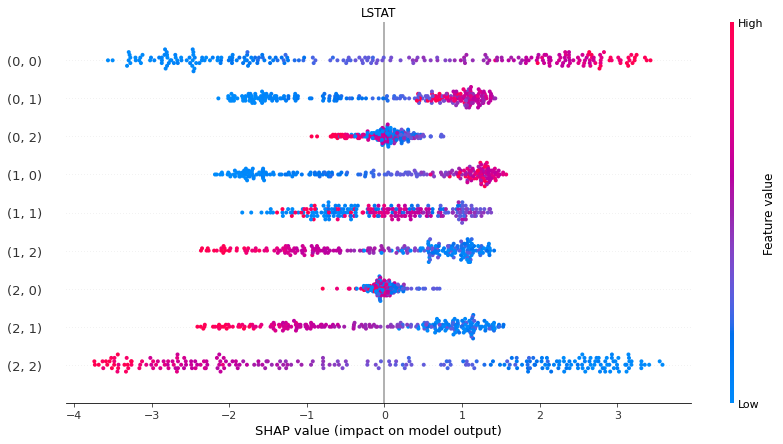

In [9]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[:1]])

For ZN, class $(1,2)$ has a group of instances, high and low feature values mixed, that have a bigger positive influence on the log odds. For class $(2,1)$, we see more low value instances near zero, making both class distribtions different. Previously, in A vs. B, they were very similar.

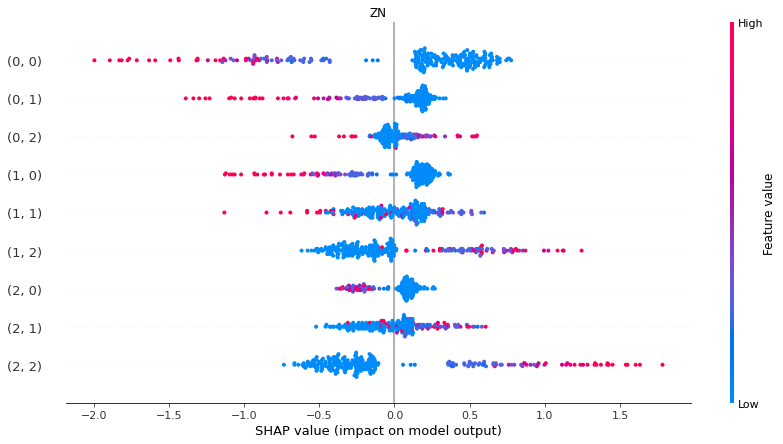

In [10]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[1:2]])

For INDUS the distributions look like in A vs. B.

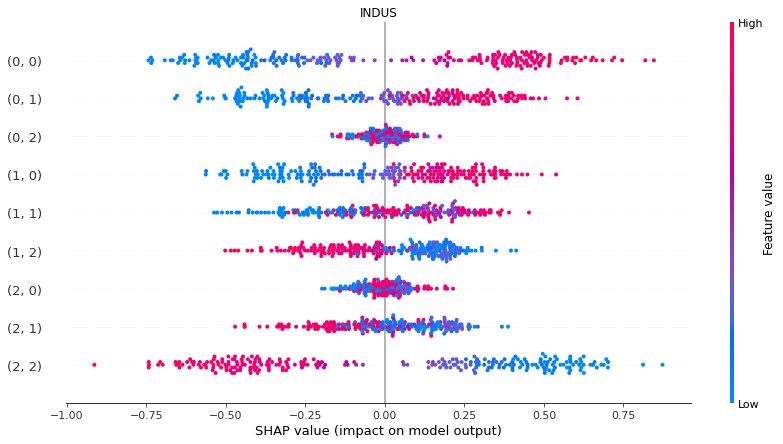

In [18]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[2:3]])

For CRIM the distributions look like in A vs. B.

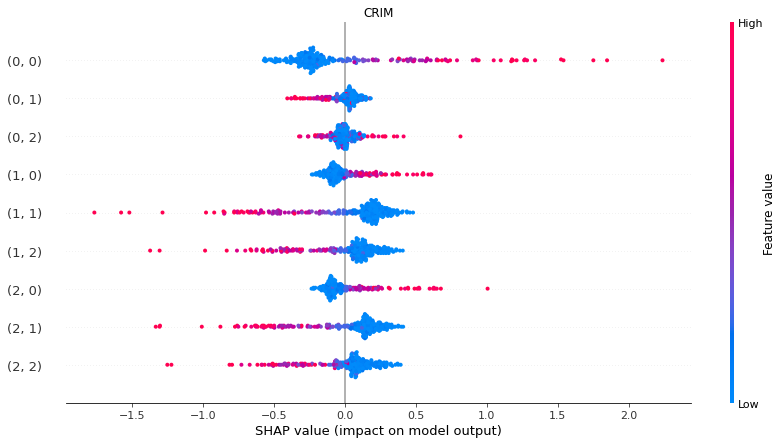

In [19]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[3:4]])

For RM the distributions look like in A vs. B.

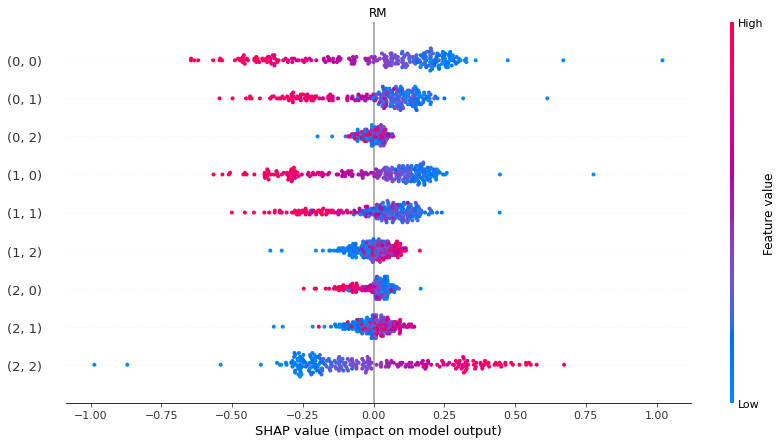

In [20]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[4:5]])

For RAD the distributions look like in A vs. B.

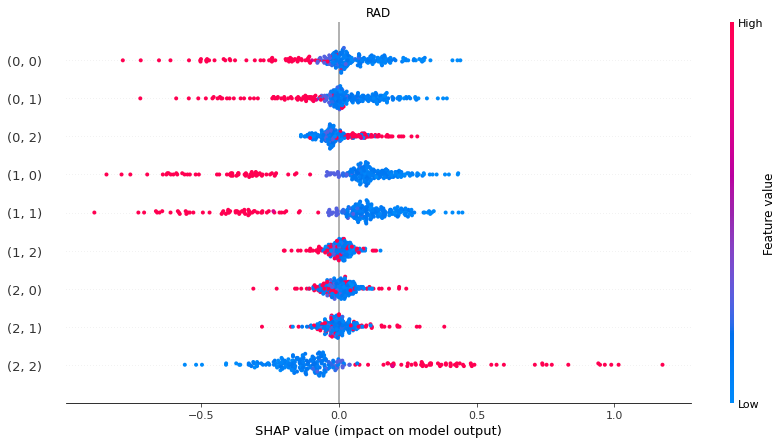

In [21]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[5:6]])

For TAX the distributions look like in A vs. B.

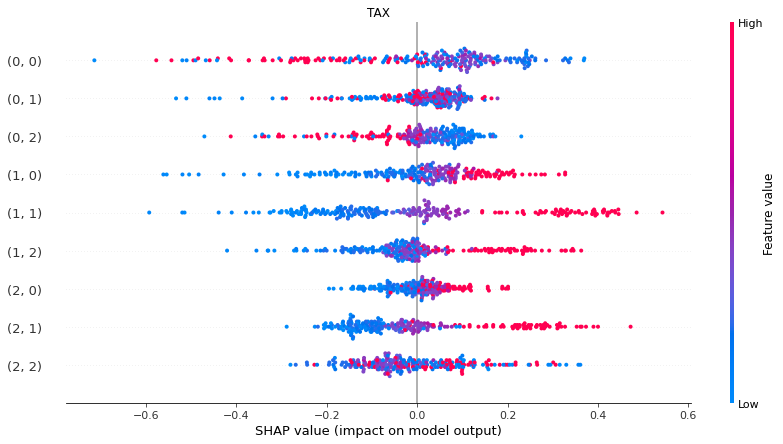

In [22]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[6:7]])

For AGE, low feature values have now higher influence on log odds of class $(0,1)$ and $(1,0)$, whereas overall the influence on $(1,2)$ and $(2,1)$ is now lower, but in contrast to the comparison A vs. B, low feature values have now bigger positive influence on class $(2,1)$.

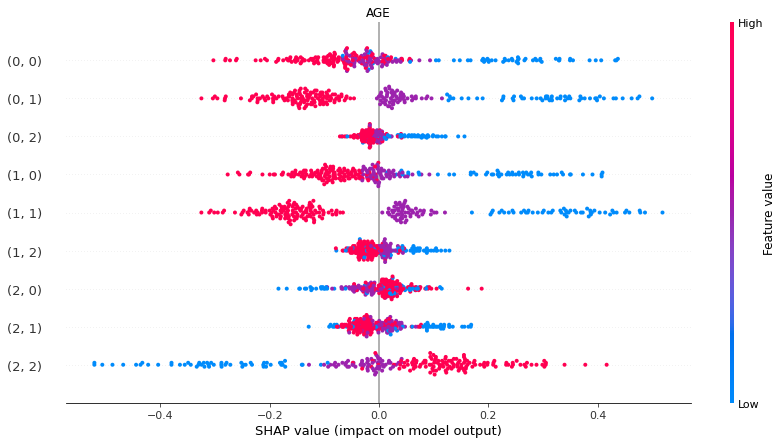

In [23]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[7:8]])

For DIS the distributions look like in A vs. B.

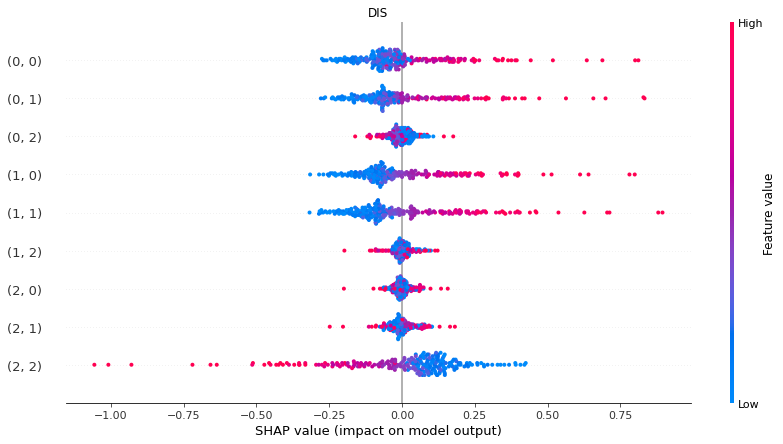

In [24]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[8:9]])

For PTRATIO the distributions look like in A vs. B.

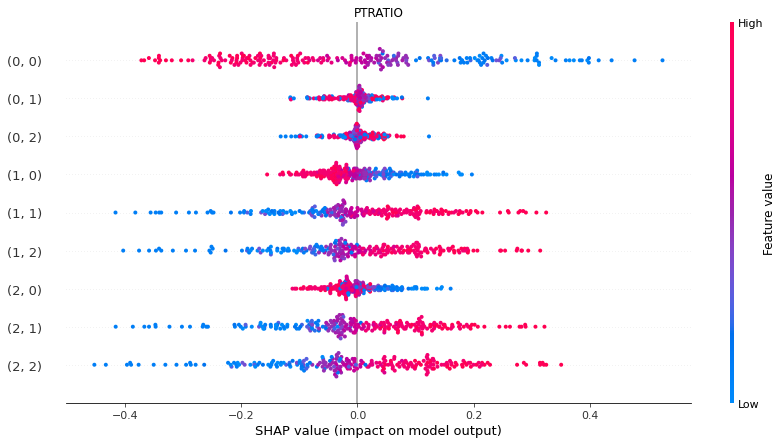

In [25]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[9:10]])

NOX may be disregarded because of its small influences.

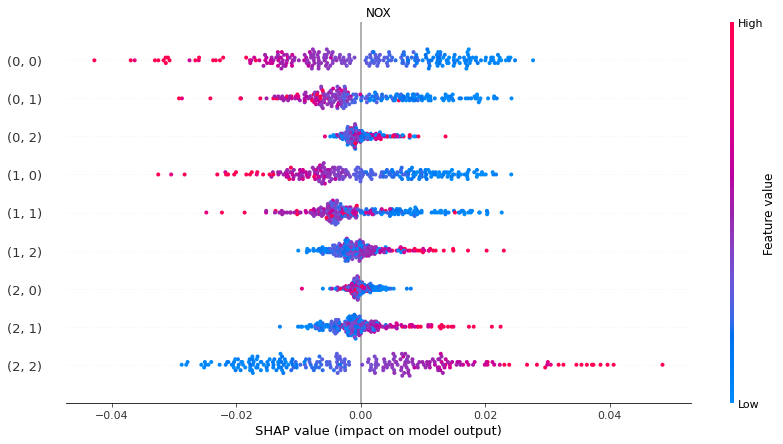

In [26]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, feature_order[10:]])

## Feature effects

### Individual explanations

There is more structure in the subtracted SHAP values (right column) than in the comparison A vs. B. It's higher around 10-15 for class 0, spread to positive and negative <10 and >15 for class 1, and higher <10 and >15 for class 2.

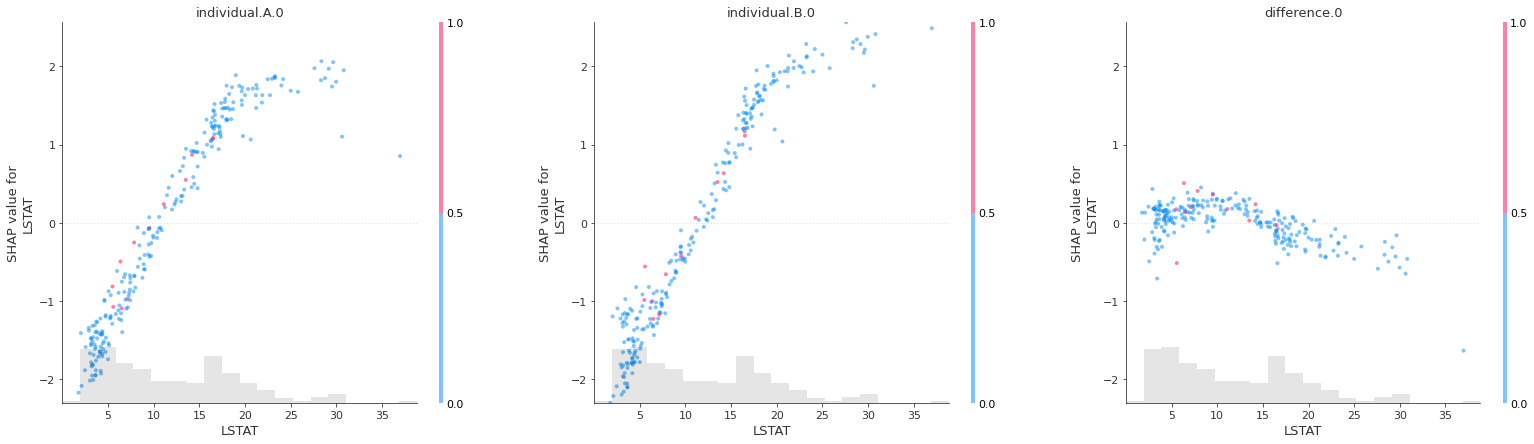

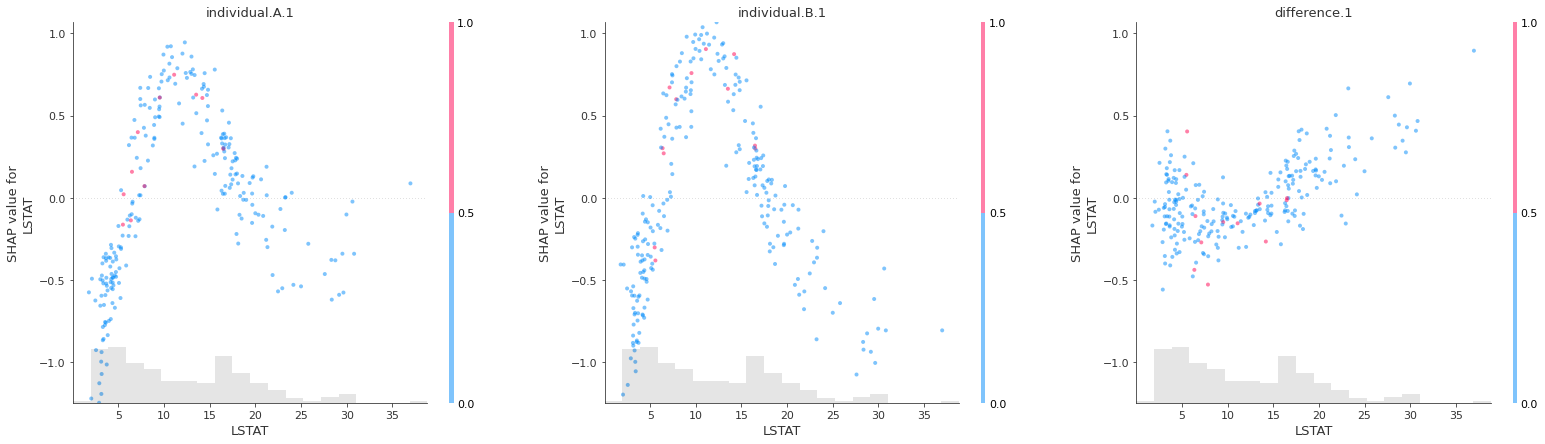

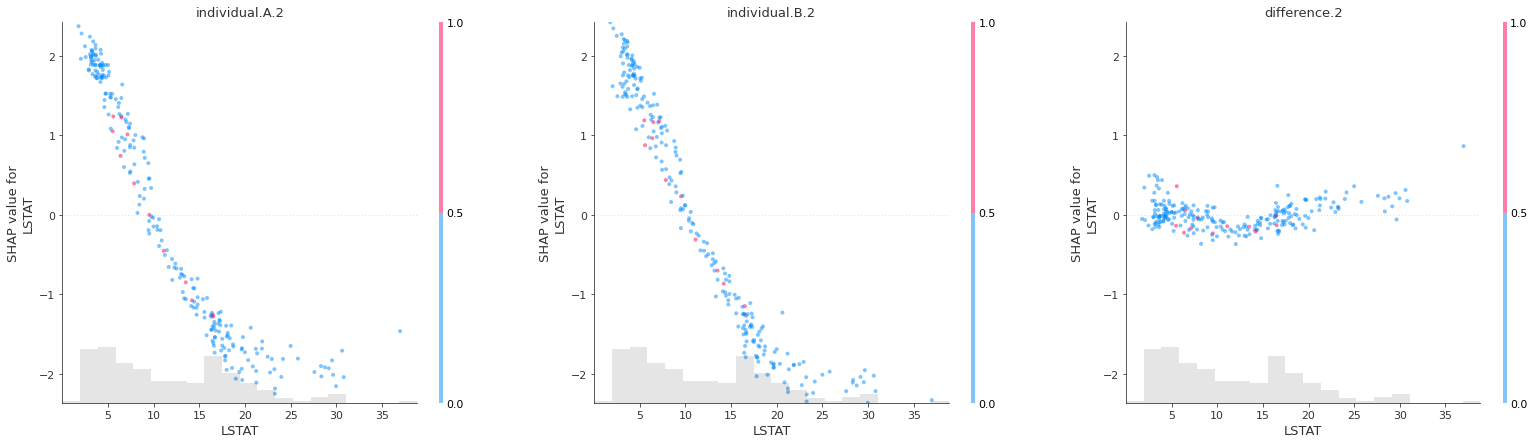

In [27]:
for class_idx in comparer.base_classes:
    plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature_order[0]], class_idx],
                                            difference=explanations.indiv_diff.log_odds[:, [feature_order[0]], class_idx]),
                         color=is_pred_diff, alpha=0.5)

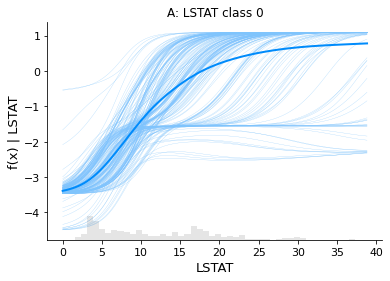

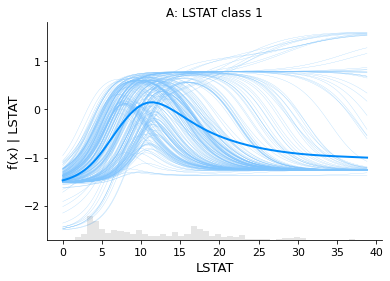

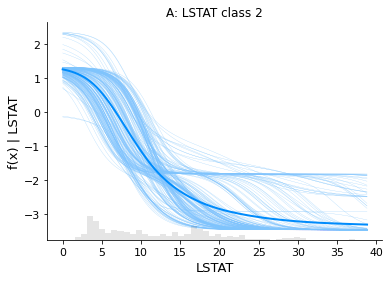

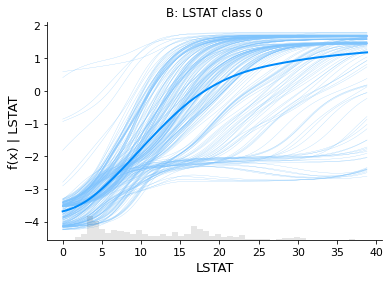

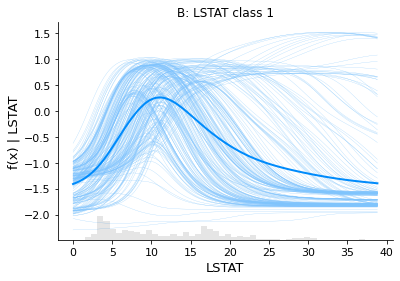

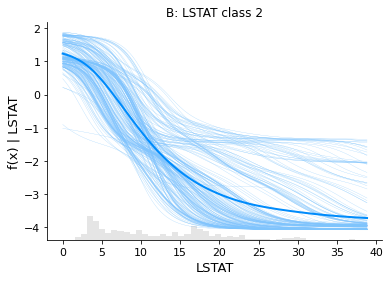

In [97]:
feature = 'LSTAT'
clf_name, class_idx = None, None
predict = lambda X: comparer.predict_log_odds_functions[clf_name](X)[:, class_idx]
for clf_name in ['A', 'B']:
    for class_idx in range(3):
        shap.partial_dependence_plot(feature, predict, X, show=False)
        plt.title(f'{clf_name}: {feature} class {class_idx}')
        plt.show()

### Difference classifier explanations

Class $(0,1)$ looks just like in the A vs. B comparison.

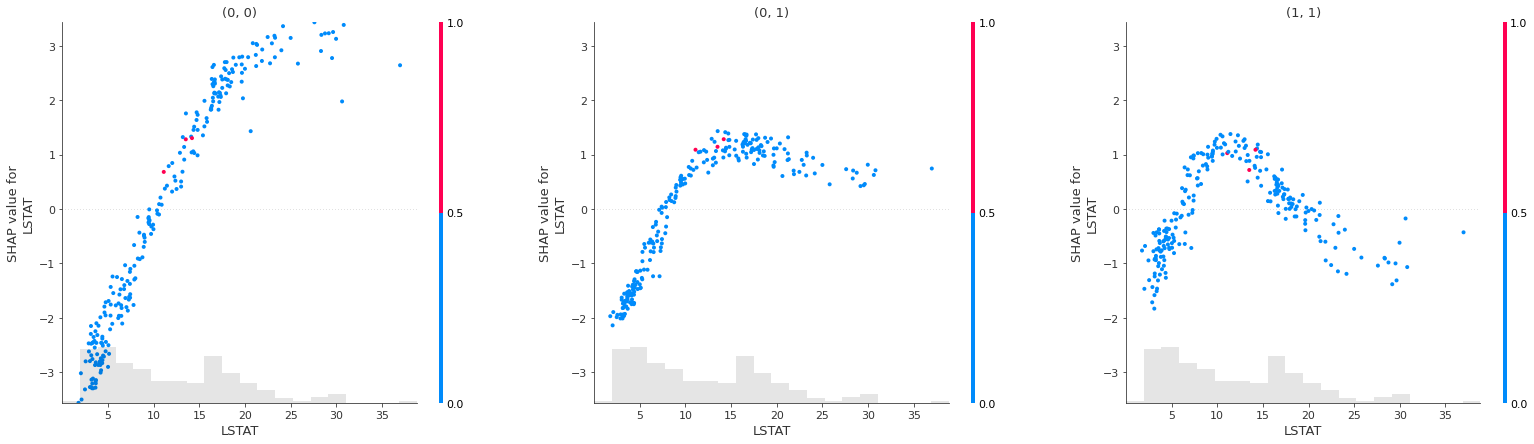

In [12]:
mask = mclass_diff == class_idx_of('(0, 1)')
shap_values = explanations.mclass_diff.log_odds[:, ['LSTAT']]
plot_feature_effects(shap_values[:, :, '(0, 0)'],
                     shap_values[:, :, '(0, 1)'],
                     shap_values[:, :, '(1, 1)'], color=mask)

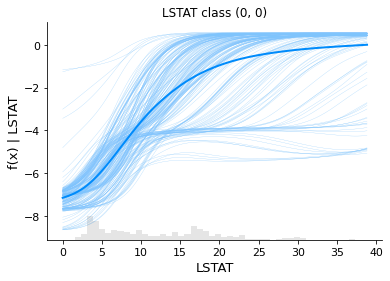

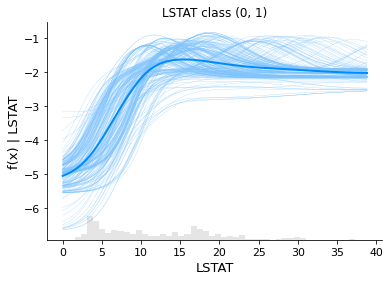

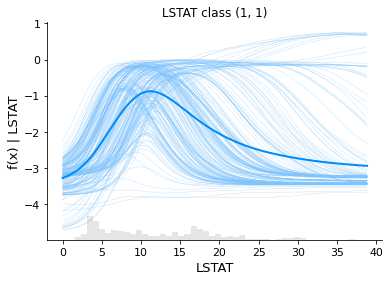

In [98]:
feature = 'LSTAT'
class_idx = None
predict = lambda X: comparer.predict_mclass_diff_log_odds(X)[:, class_idx]
for class_name in ['(0, 0)', '(0, 1)', '(1, 1)']:
    class_idx = class_idx_of(class_name)
    shap.partial_dependence_plot(feature, predict, X, show=False)
    plt.title(f'{feature} class {class_name}')
    plt.show()

In contrast to the comparison of A vs. B, class $(0,1)$ ranges from LSTAT 10.4 to 14.9, which is narrower.

In [22]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 14.9
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(0, 0)', '(0, 0)', '(0, 0)'], dtype='<U6')

In [29]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 10.4
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(1, 1)', '(1, 1)', '(1, 1)'], dtype='<U6')

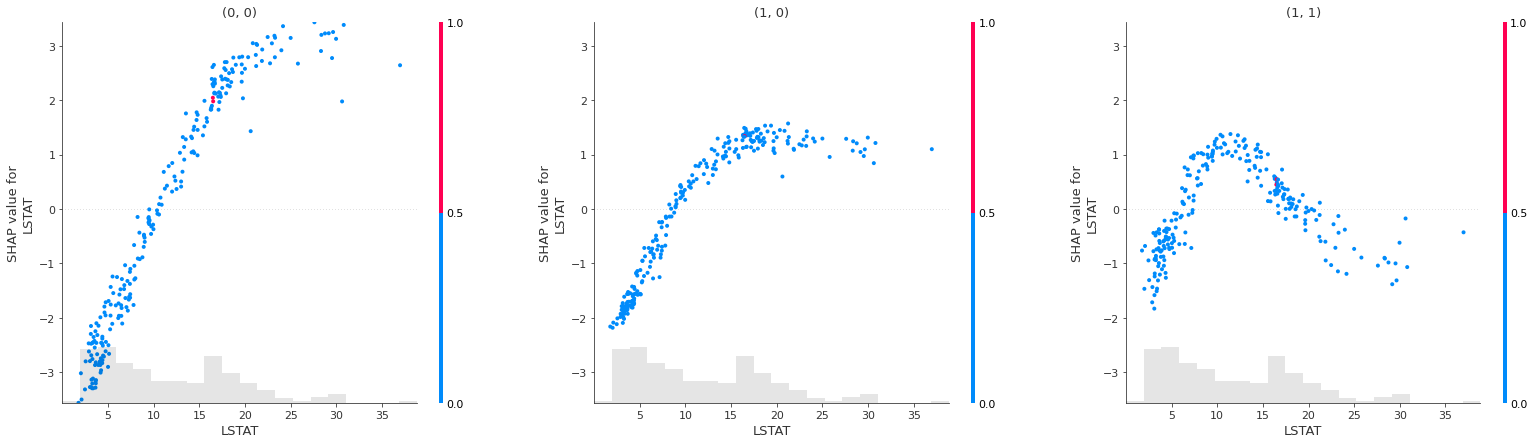

In [55]:
mask = mclass_diff == class_idx_of('(1, 0)')
shap_values = explanations.mclass_diff.log_odds[:, ['LSTAT']]
plot_feature_effects(shap_values[:, :, '(0, 0)'],
                     shap_values[:, :, '(1, 0)'],
                     shap_values[:, :, '(1, 1)'], color=mask)

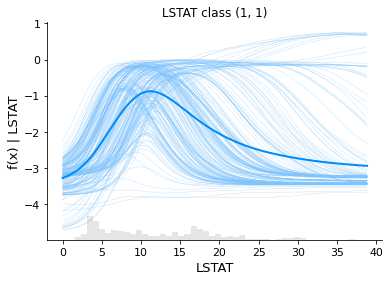

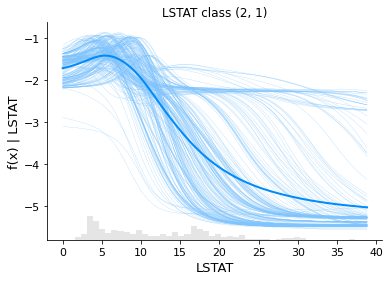

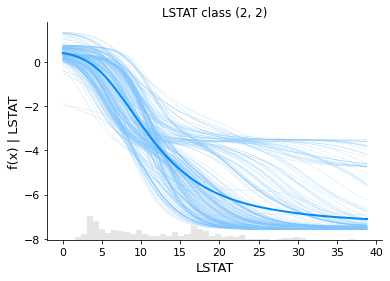

In [99]:
feature = 'LSTAT'
class_idx = None
predict = lambda X: comparer.predict_mclass_diff_log_odds(X)[:, class_idx]
for class_name in ['(1, 1)', '(2, 1)', '(2, 2)']:
    class_idx = class_idx_of(class_name)
    shap.partial_dependence_plot(feature, predict, X, show=False)
    plt.title(f'{feature} class {class_name}')
    plt.show()

In contrast to the comparison of A vs. B, class $(1,0)$ ranges from LSTAT 16.3 to 16.8, which is narrower as well.

In [63]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 16.3
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(1, 1)', '(1, 1)'], dtype='<U6')

In [70]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 16.8
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(0, 0)', '(0, 0)'], dtype='<U6')

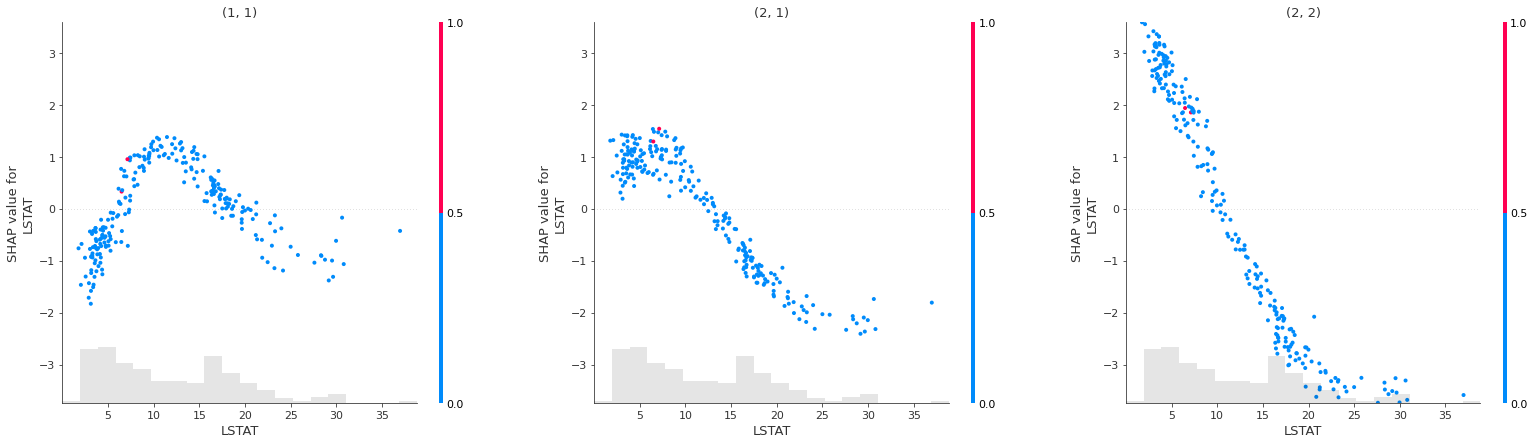

In [35]:
mask = mclass_diff == class_idx_of('(2, 1)')
shap_values = explanations.mclass_diff.log_odds[:, ['LSTAT']]
plot_feature_effects(shap_values[:, :, '(1, 1)'],
                     shap_values[:, :, '(2, 1)'],
                     shap_values[:, :, '(2, 2)'], color=mask)

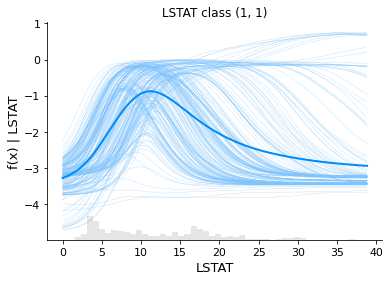

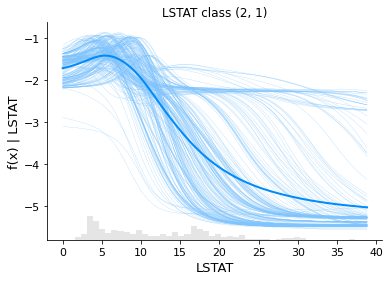

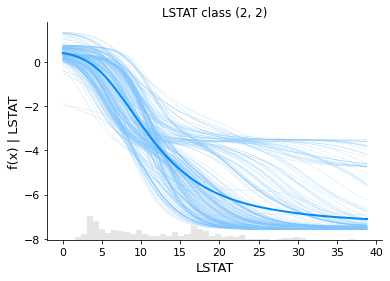

In [101]:
feature = 'LSTAT'
class_idx = None
predict = lambda X: comparer.predict_mclass_diff_log_odds(X)[:, class_idx]
for class_name in ['(1, 1)', '(2, 1)', '(2, 2)']:
    class_idx = class_idx_of(class_name)
    shap.partial_dependence_plot(feature, predict, X, show=False)
    plt.title(f'{feature} class {class_name}')
    plt.show()

In contrast to A vs. B, $(2,1)$ ranges only from 6 to 7.5, which is narrower as well.

In [54]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 7.5
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(1, 1)', '(1, 1)'], dtype='<U6')

In [53]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 6
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(2, 2)', '(2, 2)'], dtype='<U6')

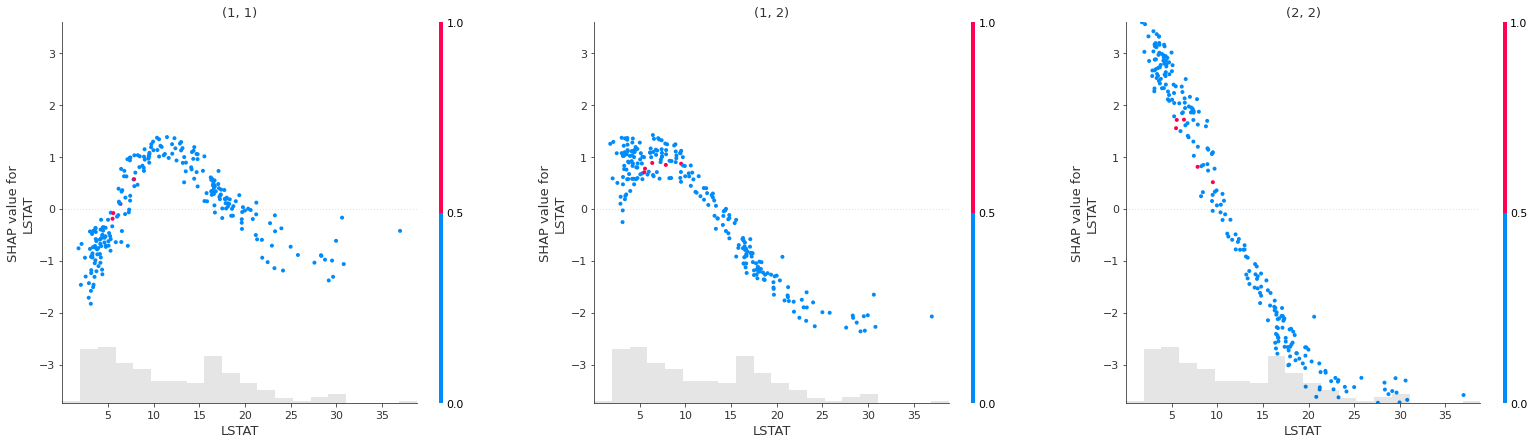

In [71]:
mask = mclass_diff == class_idx_of('(1, 2)')
shap_values = explanations.mclass_diff.log_odds[:, ['LSTAT']]
plot_feature_effects(shap_values[:, :, '(1, 1)'],
                     shap_values[:, :, '(1, 2)'],
                     shap_values[:, :, '(2, 2)'], color=mask)

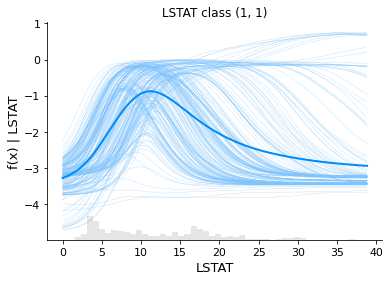

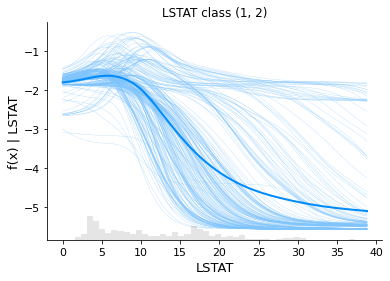

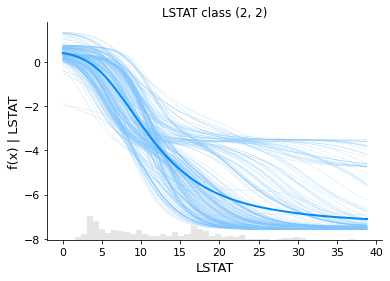

In [102]:
feature = 'LSTAT'
class_idx = None
predict = lambda X: comparer.predict_mclass_diff_log_odds(X)[:, class_idx]
for class_name in ['(1, 1)', '(1, 2)', '(2, 2)']:
    class_idx = class_idx_of(class_name)
    shap.partial_dependence_plot(feature, predict, X, show=False)
    plt.title(f'{feature} class {class_name}')
    plt.show()

For class $(1,2)$, it's different. Values are predicted for this class from 3.5 to 11.6, which is much broader than when comparing A vs. B.

In [88]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 11.6
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)', '(1, 1)'], dtype='<U6')

In [96]:
d = explanations.mclass_diff.log_odds[mask].data.copy()
d[:, feature_idx_of('LSTAT')] = 3.5
p = comparer.predict_mclass_diff(d)
comparer.class_names[p]

array(['(2, 2)', '(2, 2)', '(2, 2)', '(2, 2)', '(2, 2)'], dtype='<U6')

This is more or less the same as in A vs. B.

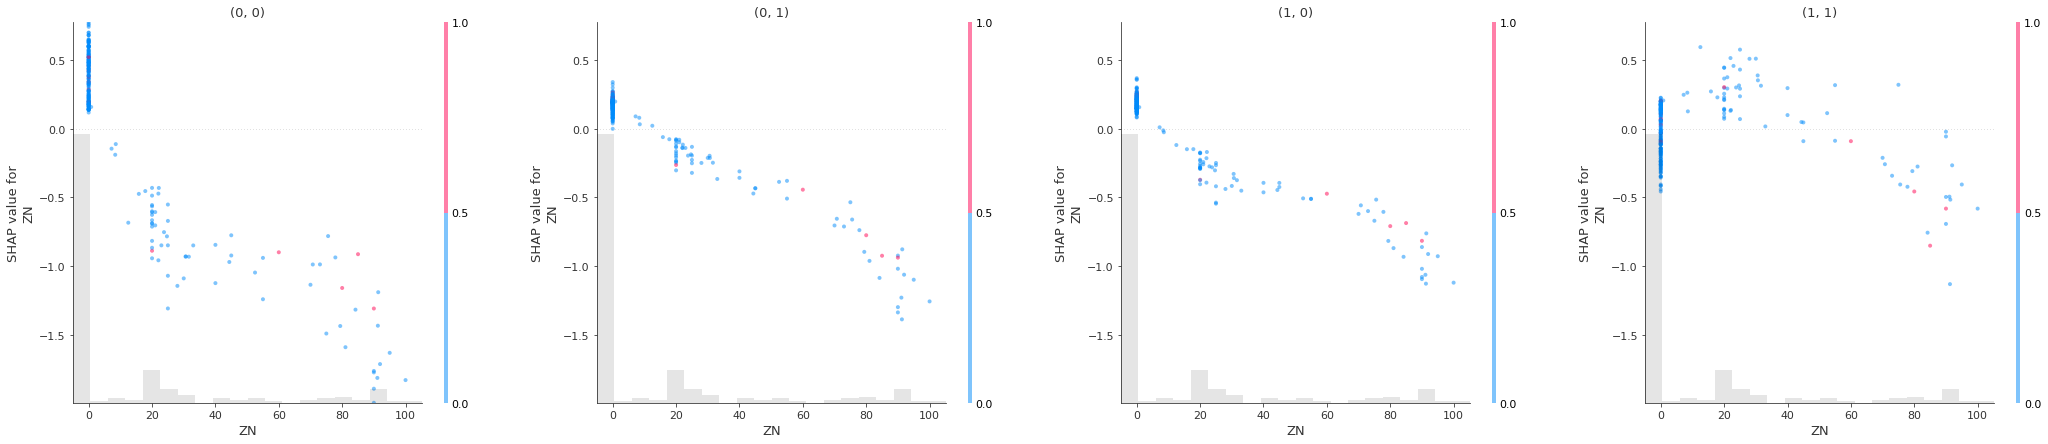

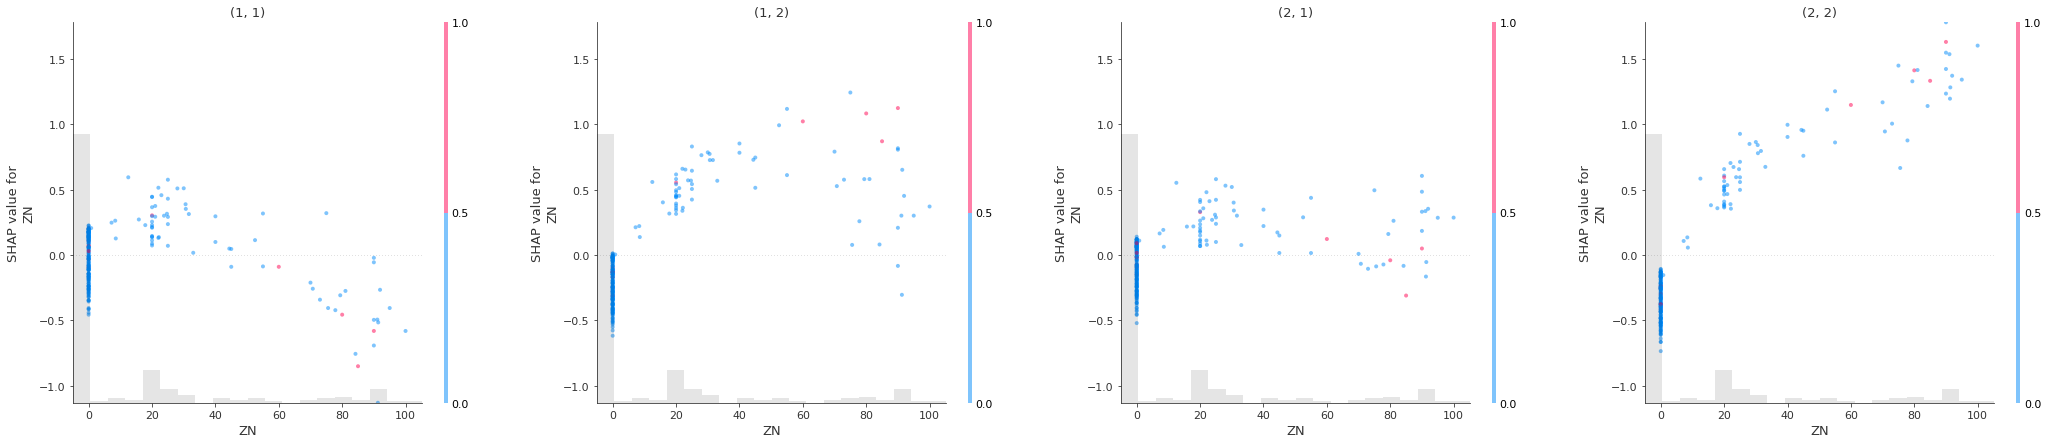

In [45]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[1:2]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

This is more or less the same as in A vs. B.

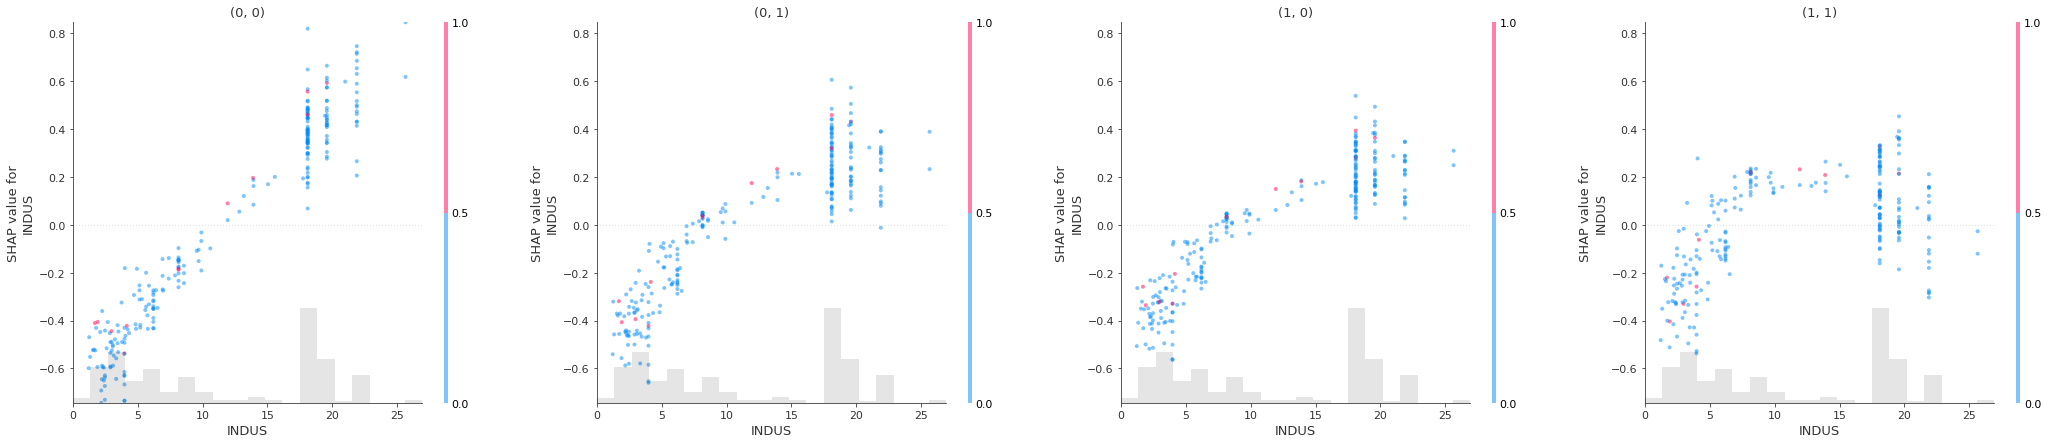

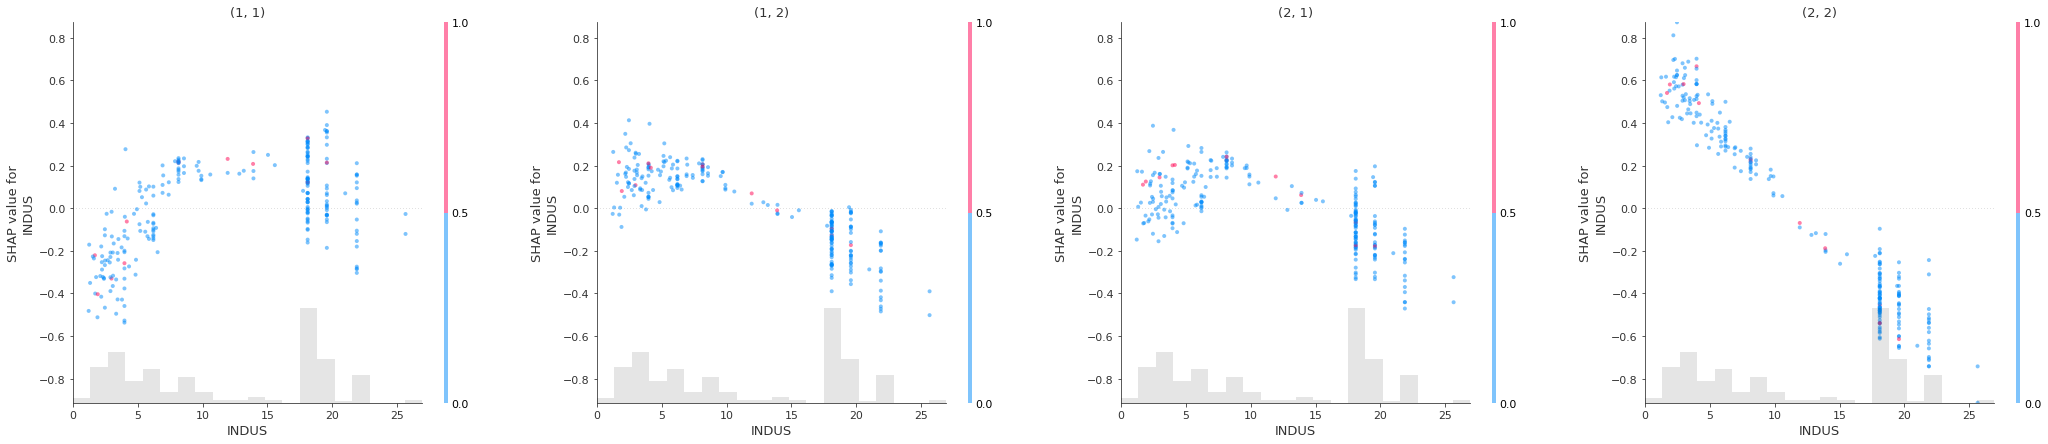

In [46]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[2:3]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

This is more or less the same as in A vs. B.

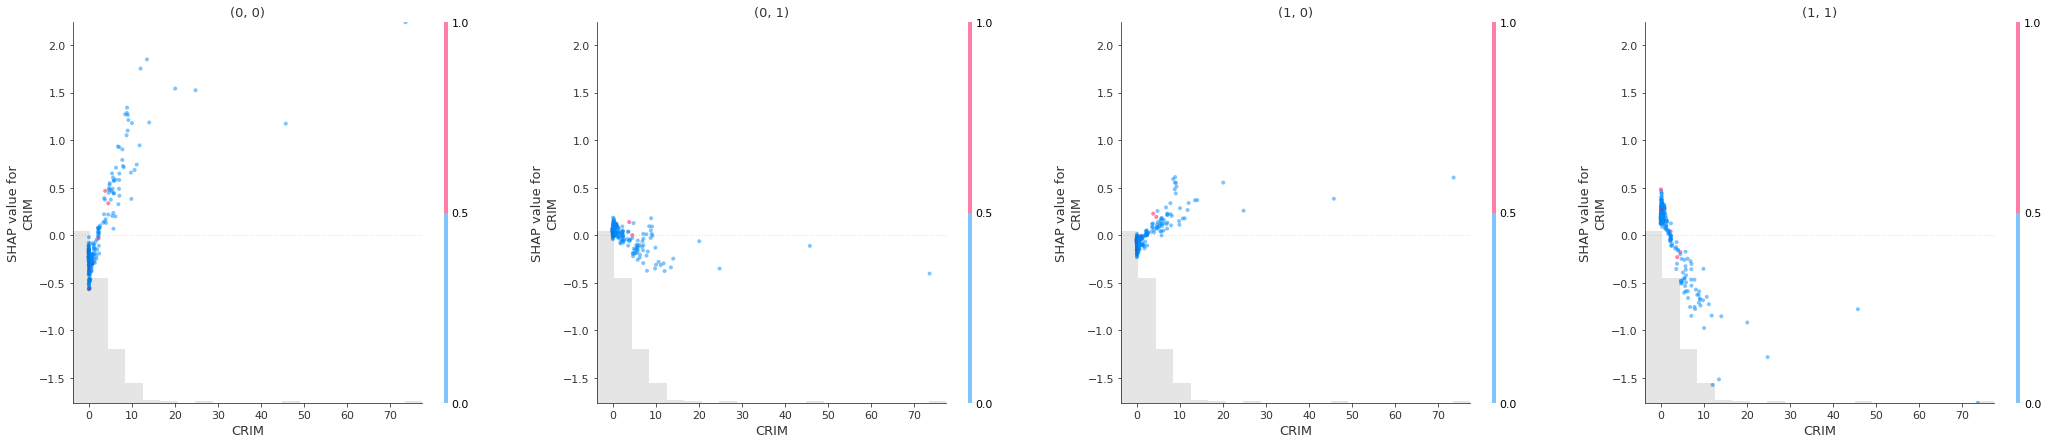

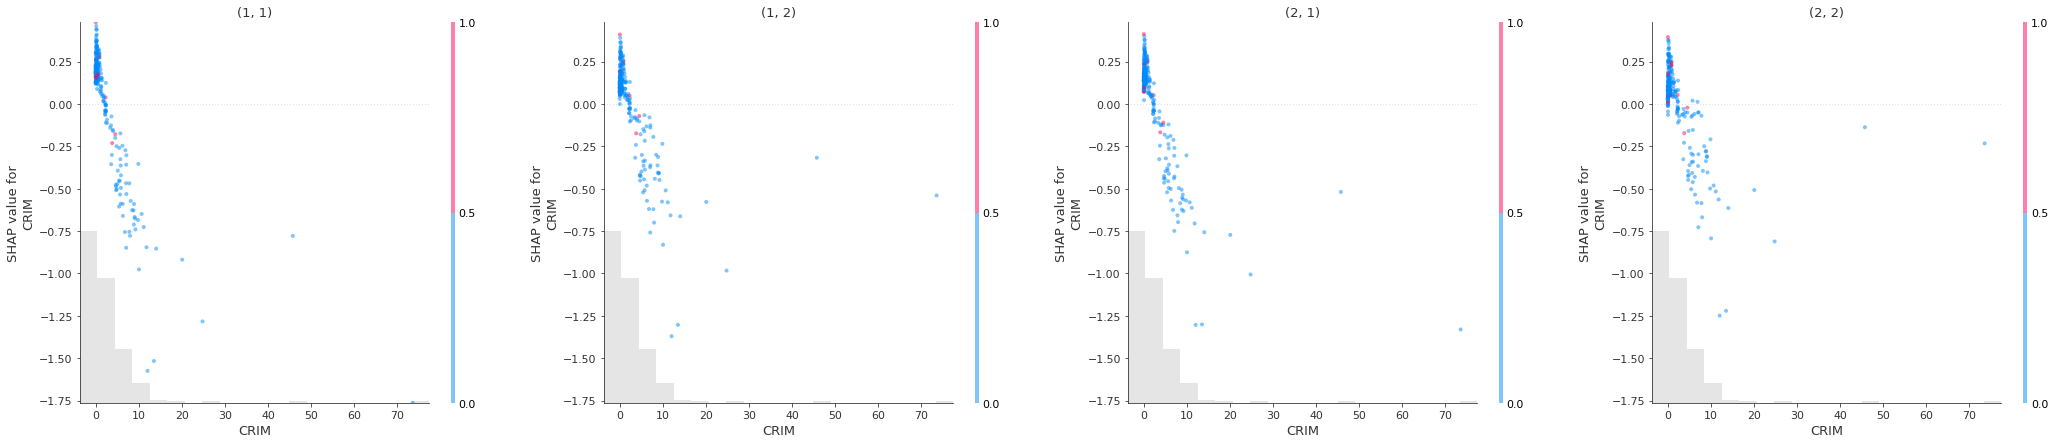

In [47]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[3:4]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

This is more or less the same as in A vs. B.

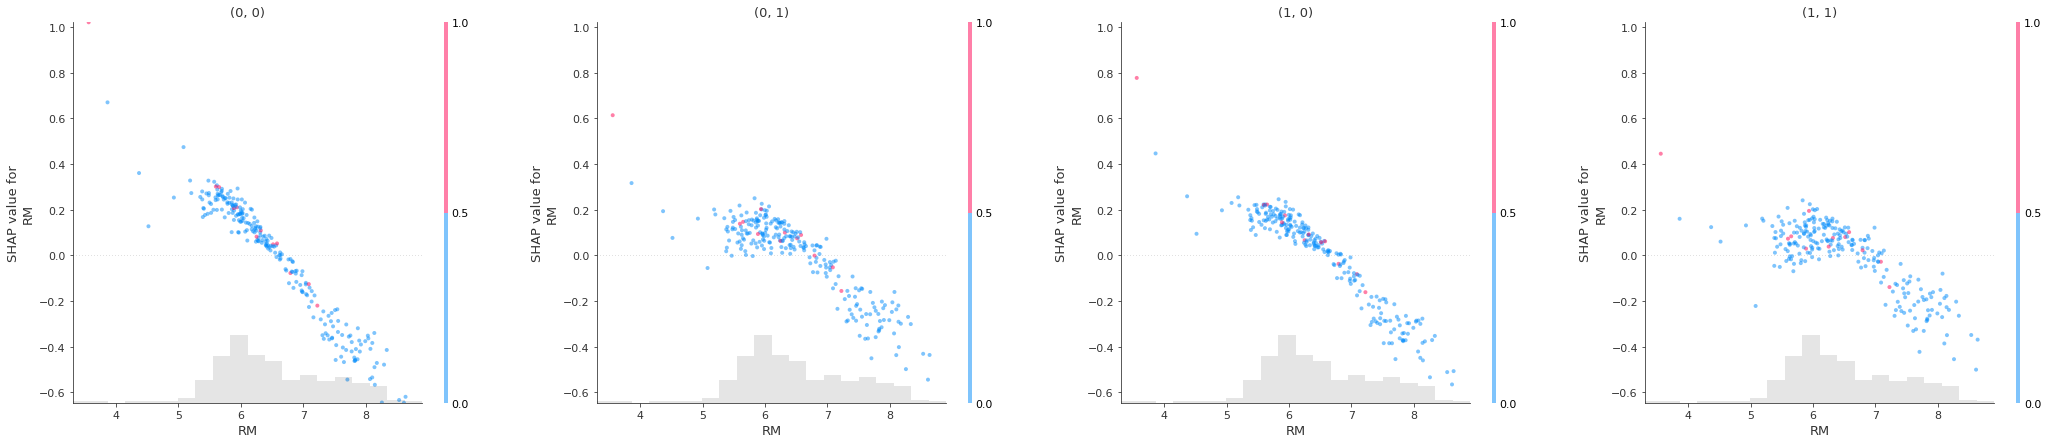

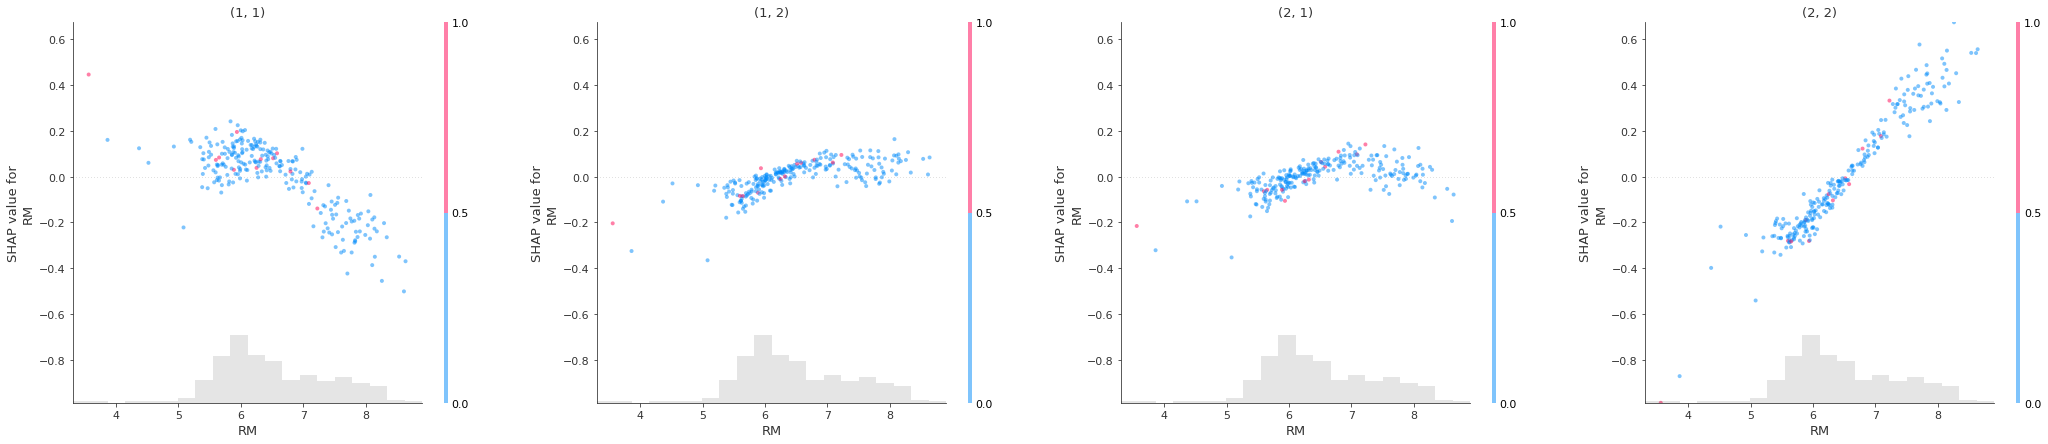

In [48]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[4:5]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

This is more or less the same as in A vs. B.

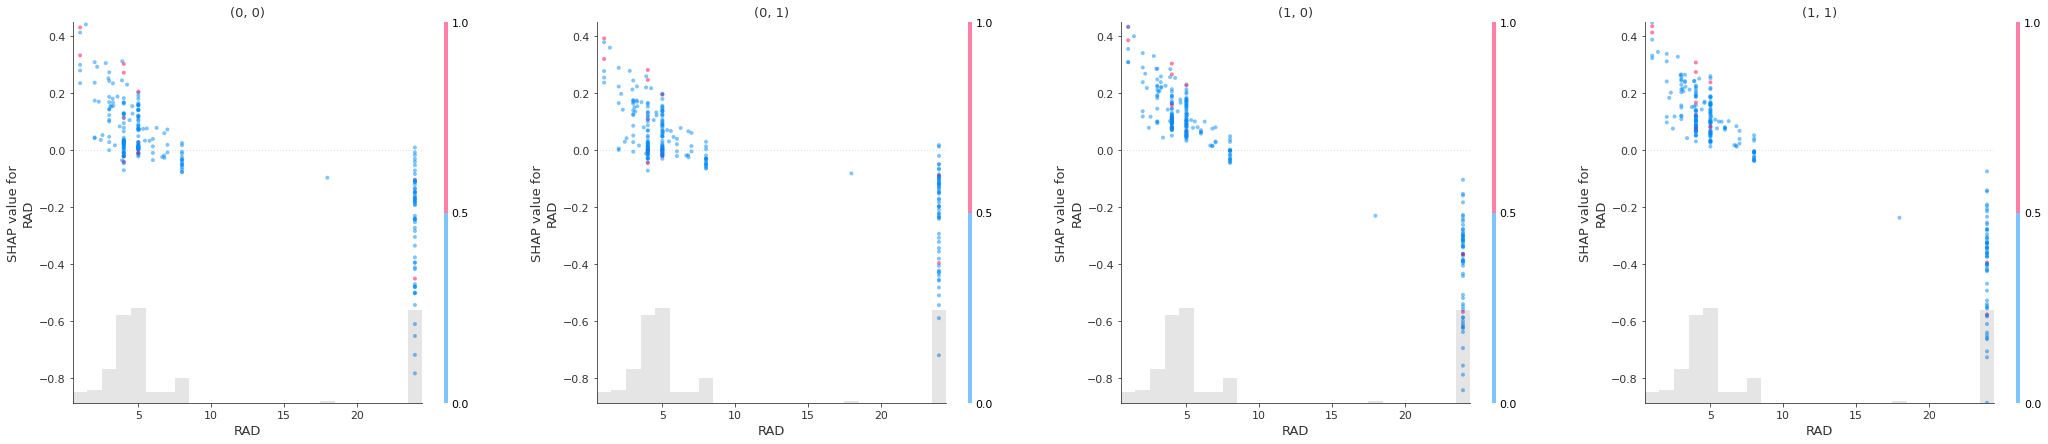

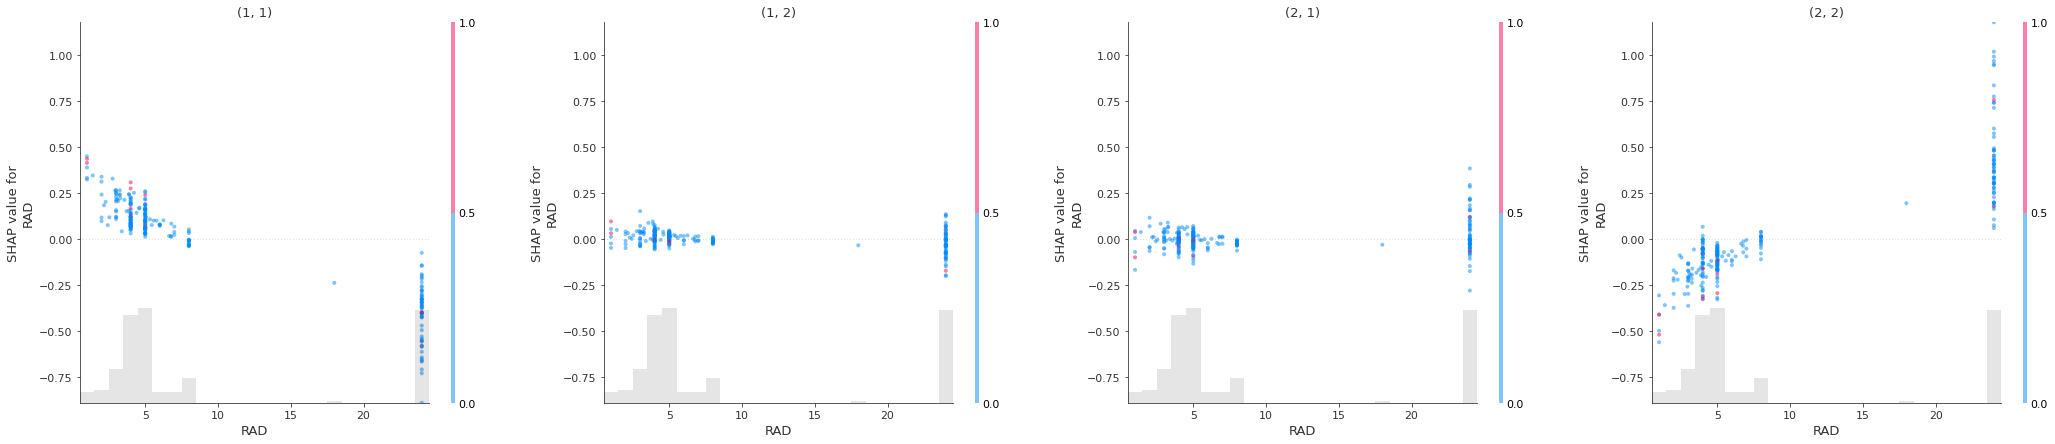

In [49]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[5:6]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

For TAX, we see shifted log odds for class $(1,0)$ compared to A vs. B. This means, that high feature values have higher influence towards the class.

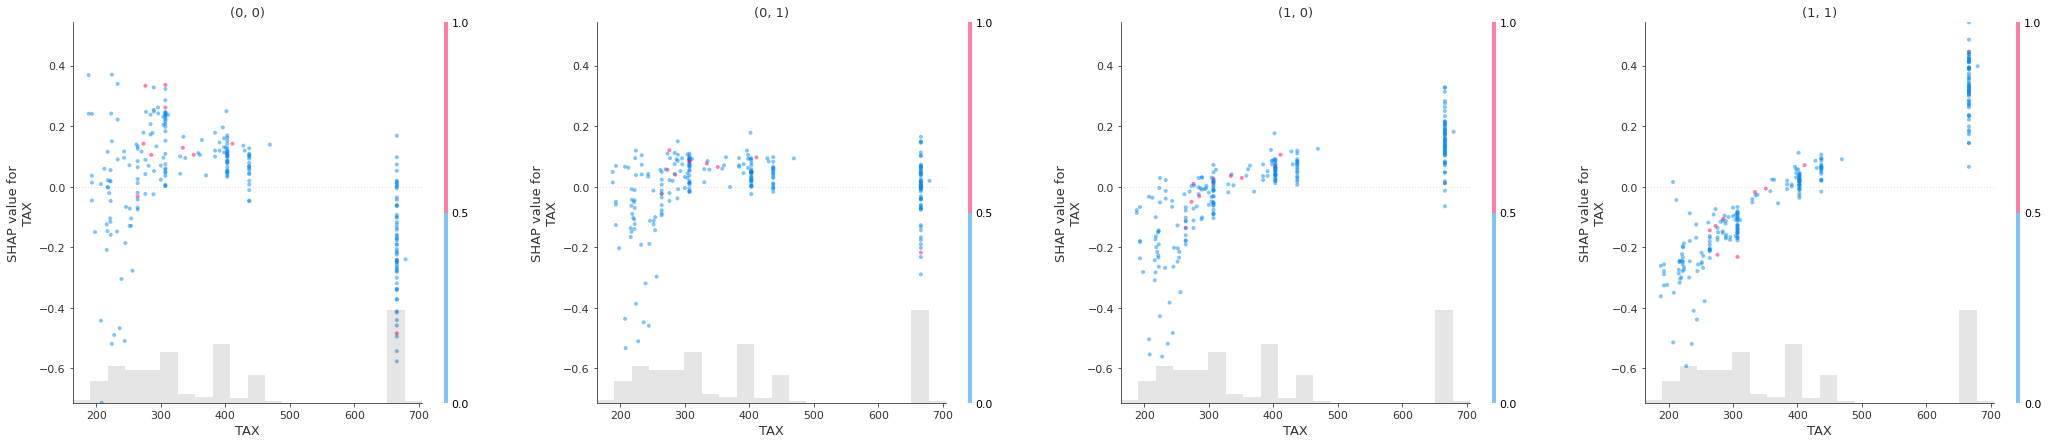

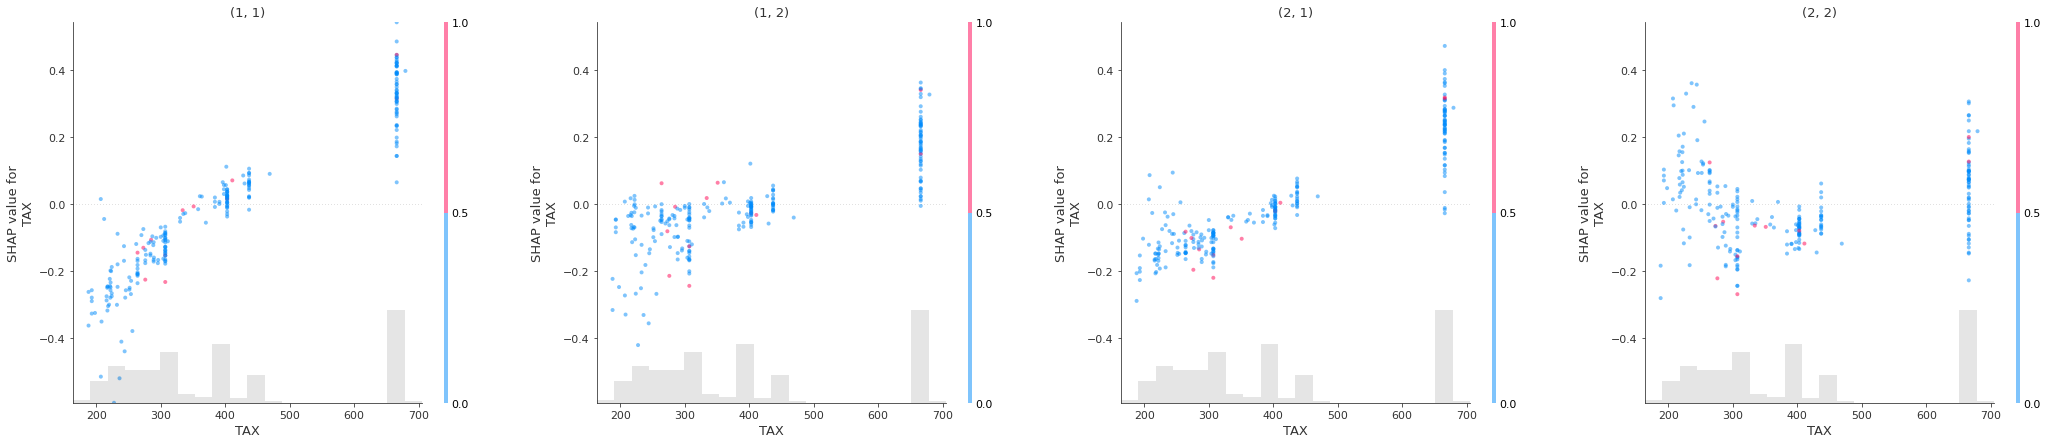

In [50]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[6:7]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

AGE has a higher, and more distinct effect on classes $(0,1)$ and $(1,0)$ than for A vs. B. But it has an indifferent effect on classes $(1,2)$ and $(2,1)$, not observed in A vs. B.

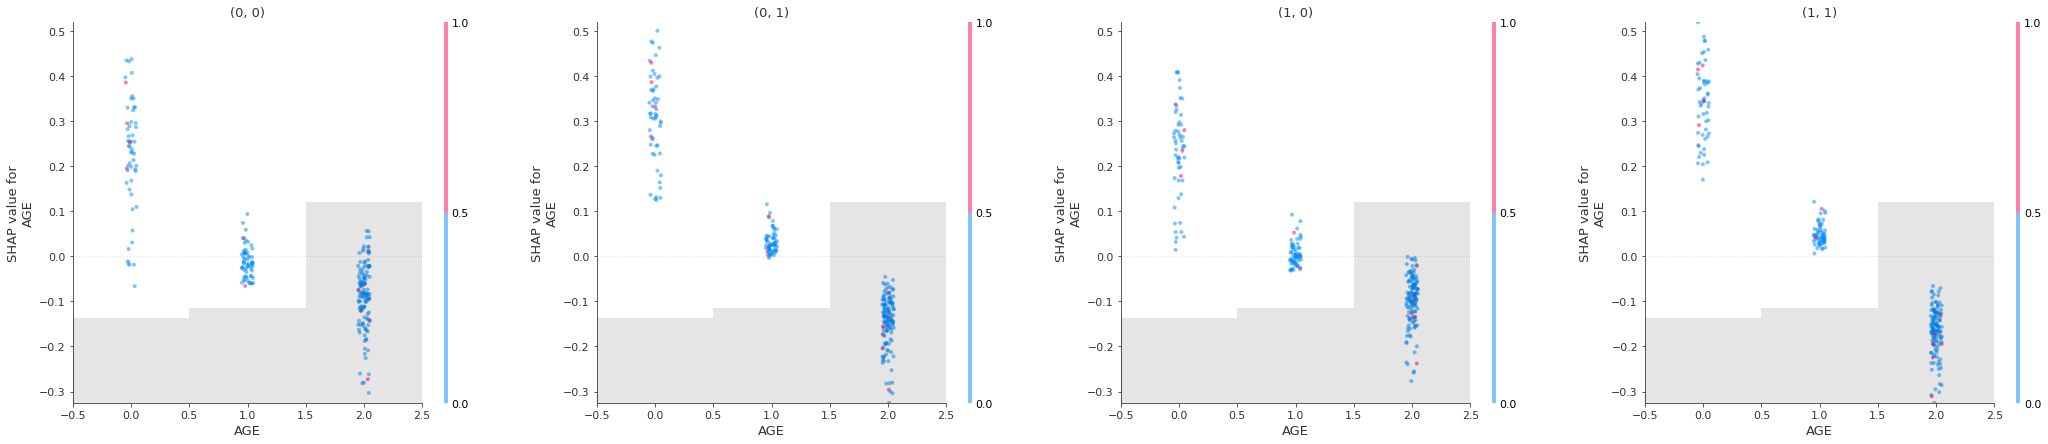

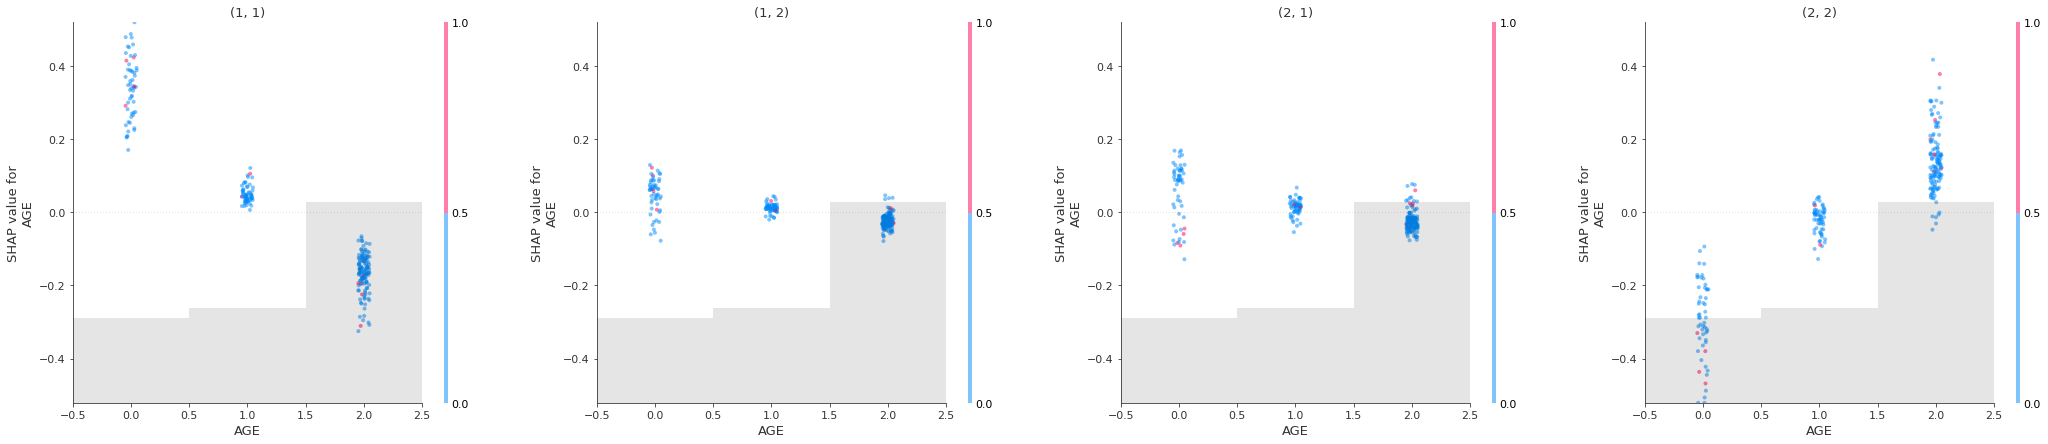

In [51]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[7:8]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

This is more or less the same as in A vs. B.

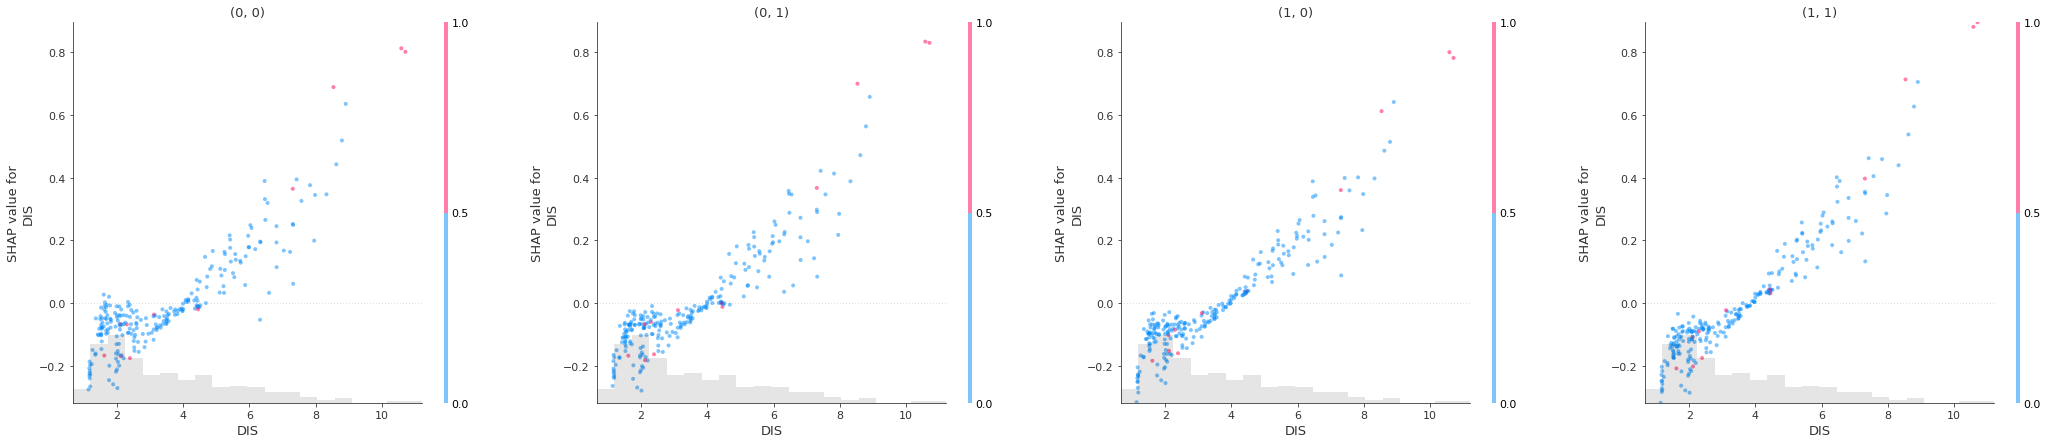

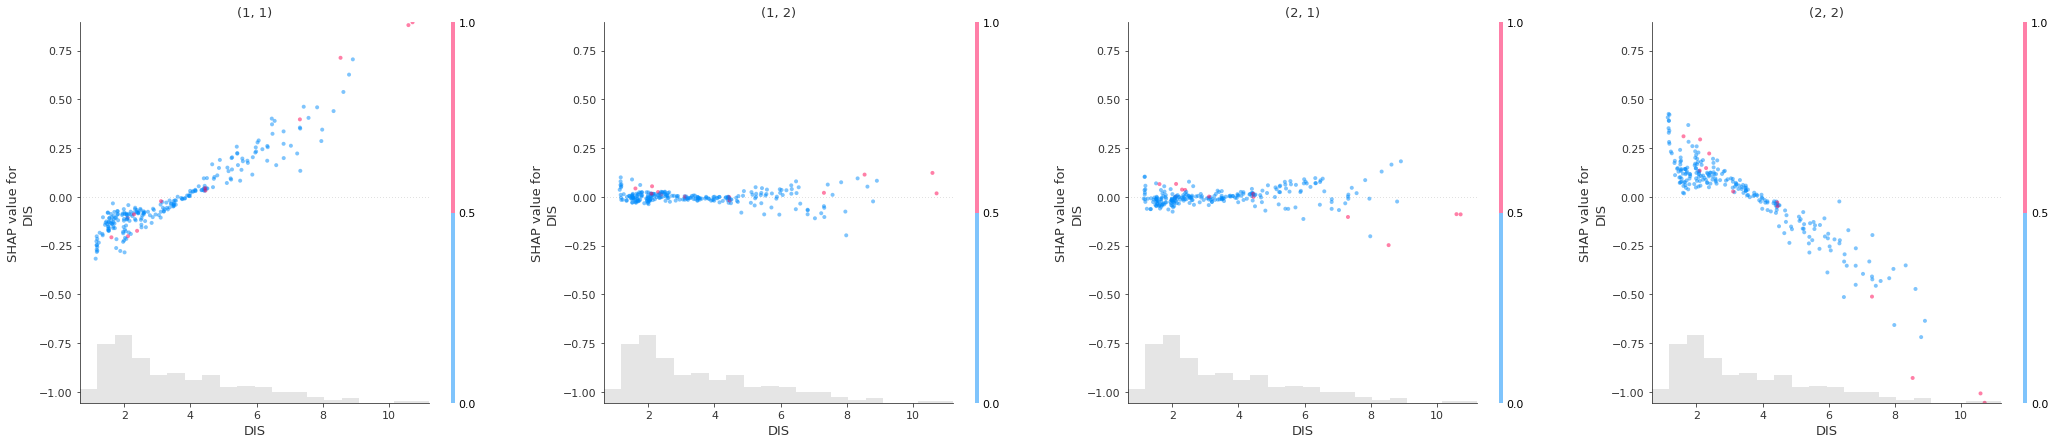

In [52]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[8:9]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

This is more or less the same as in A vs. B.

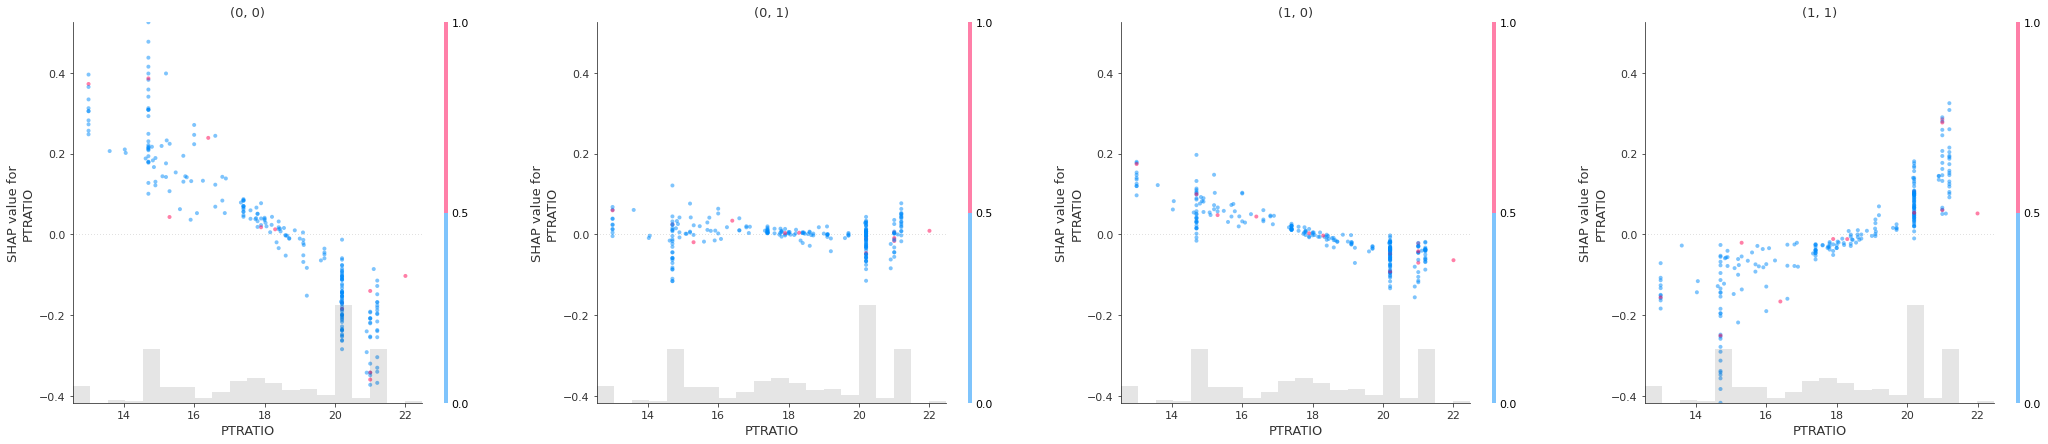

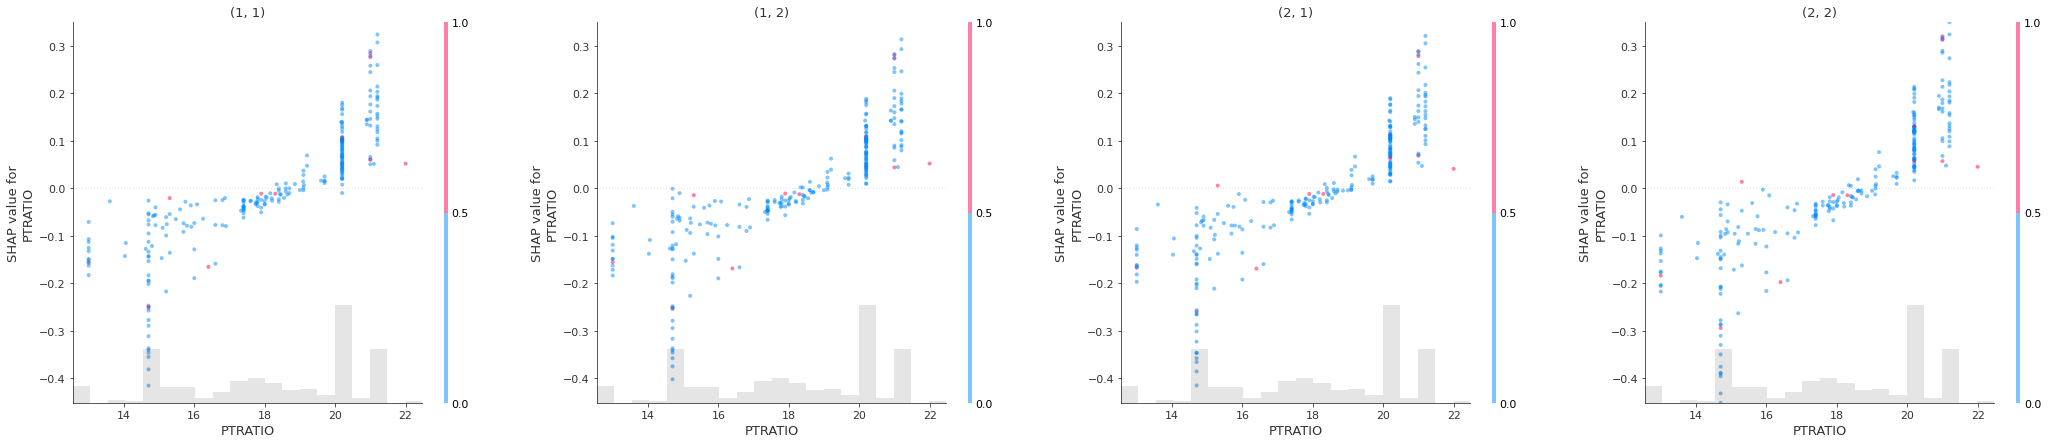

In [53]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[9:10]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

There are also effects of NOX, but they're really small compared to the other features.

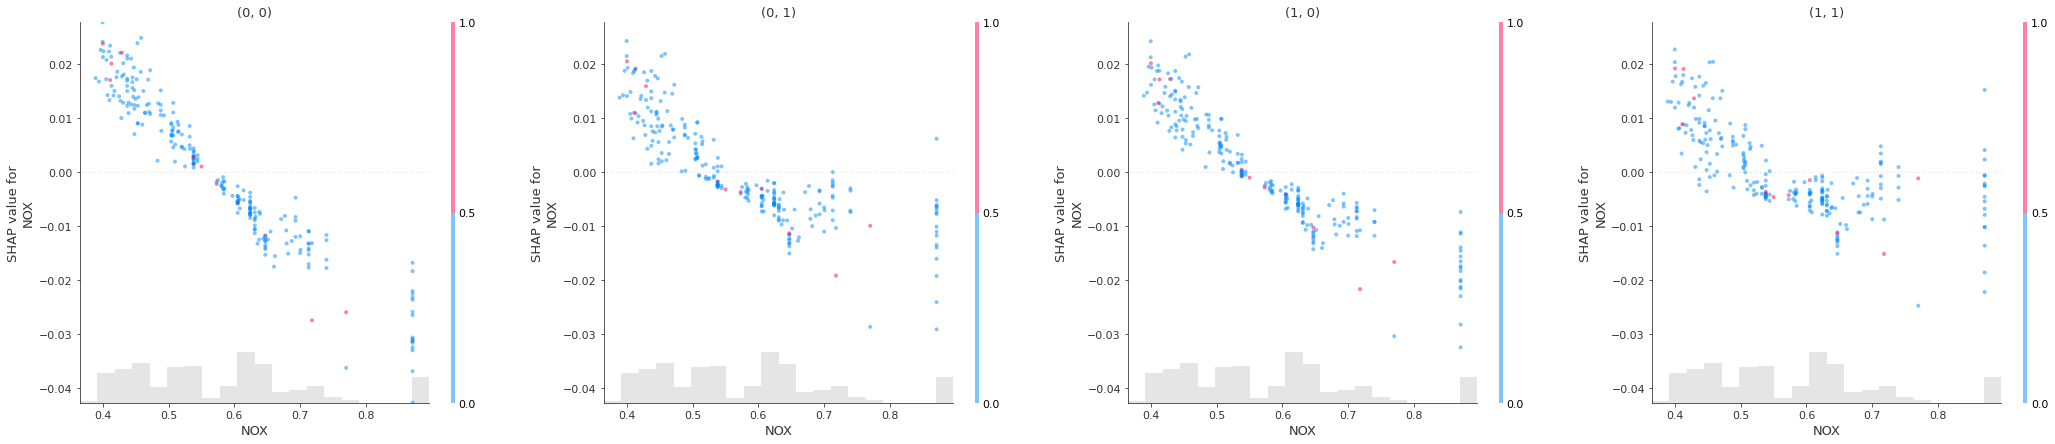

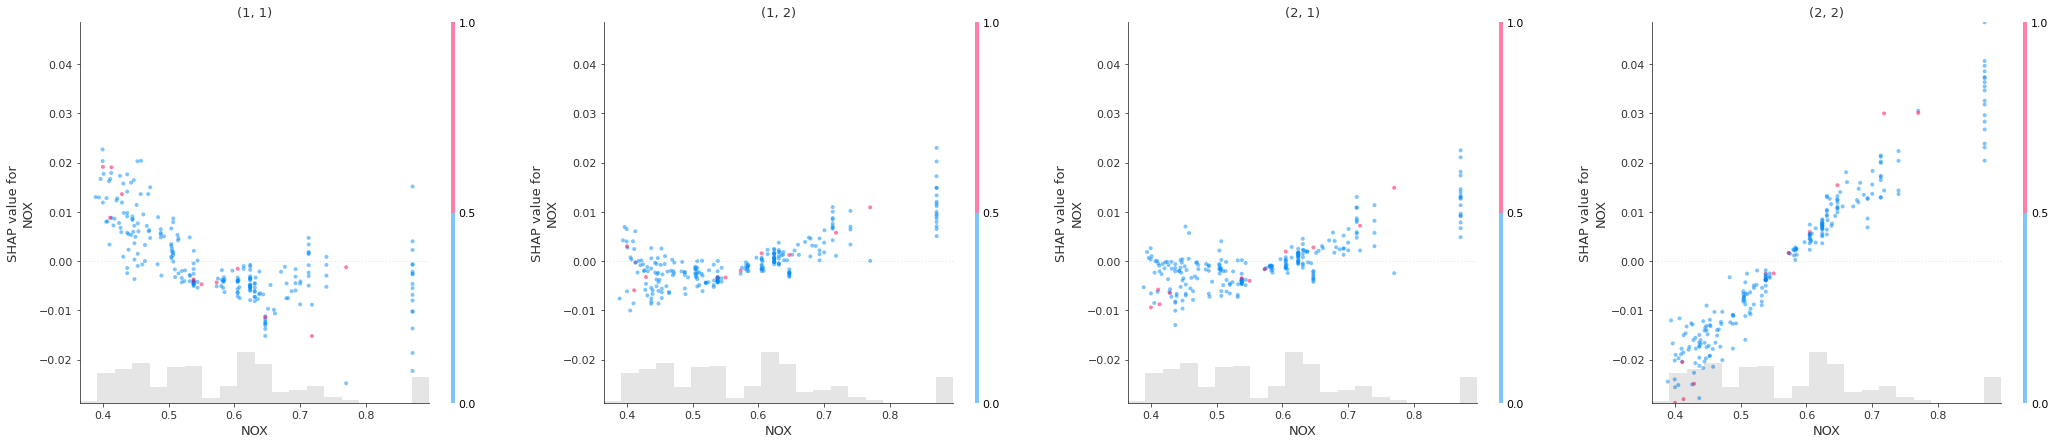

In [54]:
shap_values = explanations.mclass_diff.log_odds[:, feature_order[10:]]
plot_feature_effects(shap_values[:, :, ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']], color=is_pred_diff, alpha=0.5)
plot_feature_effects(shap_values[:, :, ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']], color=is_pred_diff, alpha=0.5)

# Conclusion

**About the two different explainability methods:**

Similar to the comparison A vs. B, PDP plots showed the same trend.

**Confidence in SHAP explanations:**

Again, I'm pretty confident (1 on a scale of up to 4) about the decision boundaries of LSTAT, after investigating the SHAP values on a global level.